In [1]:
import matplotlib.pyplot as plt
from numpy import load
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter,extrema
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.ndimage import zoom
from scipy.spatial.distance import pdist
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib as mpl

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.path import Path
from matplotlib.collections import LineCollection
from sklearn.decomposition import PCA
from scipy.stats import entropy

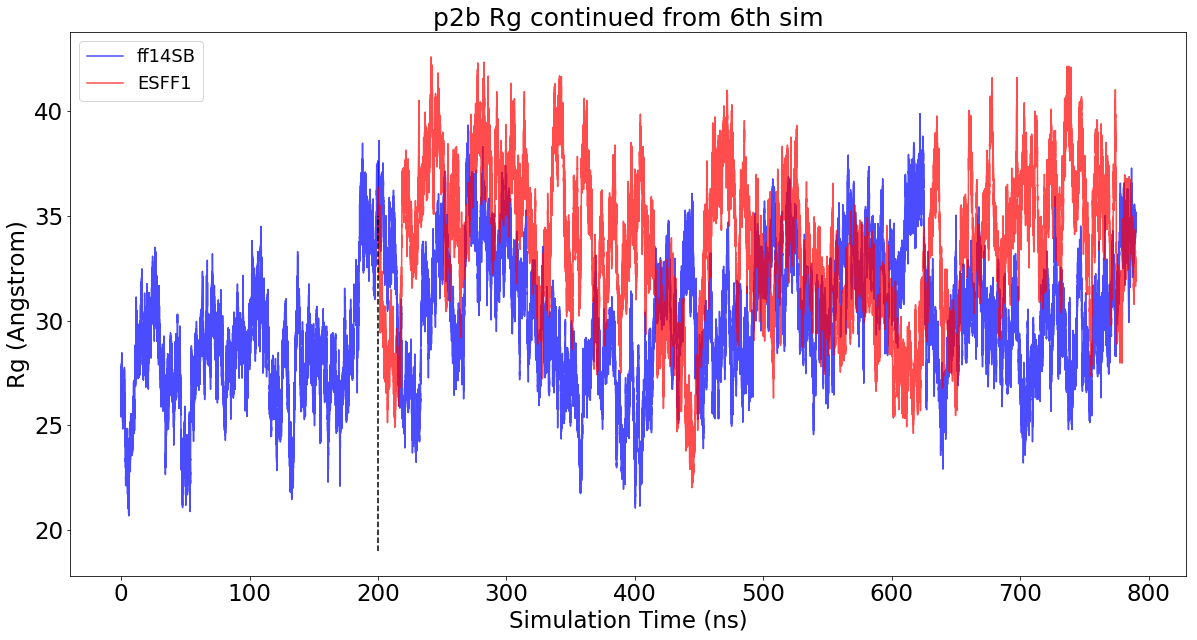

In [5]:
#continued from 6th simulation with same seed, same starting velocities
p2b_rg_newff=pd.read_csv("p2b_Rg_sixth_newff.csv")
p2b_rg_oldff=pd.read_csv('p2b_Rg_sixth_oldff.csv')
p2b_rg_sixth=pd.read_csv('P2b_Rg_master_out.csv').iloc[:,:3]
fig,ax = plt.subplots(figsize=(20,10))
plt.plot(p2b_rg_sixth[p2b_rg_sixth.sim==6].frames.values/500,
         p2b_rg_sixth[p2b_rg_sixth.sim==6].Rg.values,color='blue',
        alpha=0.7)
plt.plot((p2b_rg_oldff.frames.values/500)+200,
         p2b_rg_oldff.Rg.values,label='ff14SB',
         alpha=0.7,color='blue')
plt.plot((p2b_rg_newff.frames.values/500)+200,
         p2b_rg_newff.Rg.values,label='ESFF1',alpha=0.7,
         color='red')
cutoff = 100000/500
plt.plot([cutoff,cutoff],[19,35],color='black',
         linestyle='dashed')
plt.xlabel('Simulation Time (ns)',size=23)
plt.ylabel('Rg (Angstrom)',size=23)
plt.title('p2b Rg continued from 6th sim', size=25)
plt.setp(ax.get_yticklabels(), fontsize=23)
plt.setp(ax.get_xticklabels(), fontsize=23)
plt.legend(fontsize=18)
#plt.xlim(200,200

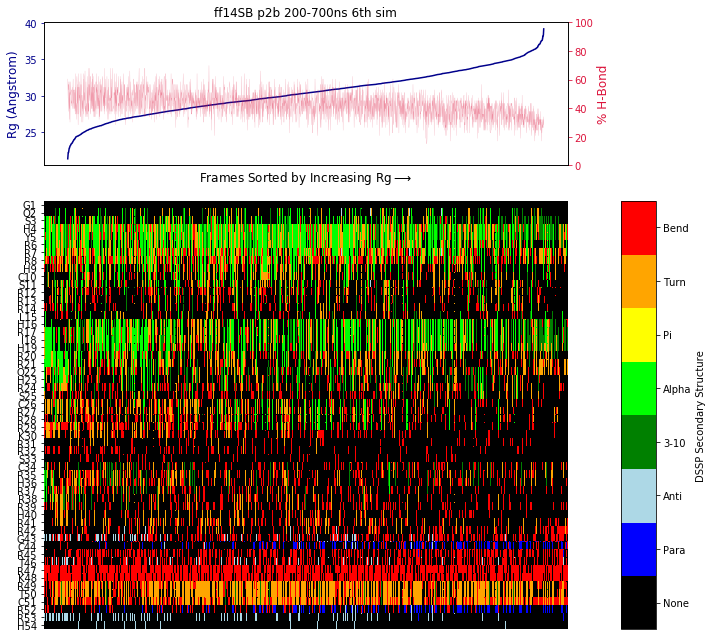

In [6]:
p2b_secstruc_sixth_oldff=pd.read_csv("p2b_secstruct_sixth_oldff.csv")
p2b_rg_oldff=pd.read_csv('p2b_Rg_sixth_oldff.csv')
frame_counts=p2b_secstruc_sixth_oldff.Frames.max()
secstruc_bool=(p2b_secstruc_sixth_oldff.Frames==frame_counts) 
p2b_secstruc_sixth_oldff=p2b_secstruc_sixth_oldff[~secstruc_bool]
temp_secstruc=p2b_secstruc_sixth_oldff.Secstruct.values
temp_secstruc=temp_secstruc.reshape((int(temp_secstruc.shape[0]/54)),54)
temp_secstruc=pd.DataFrame(data=temp_secstruc,
                           columns=p2b_secstruc_sixth_oldff.Residues.unique())
p2b_secstruc_sixth_oldff=pd.concat([p2b_rg_oldff.iloc[:,0],
                                        temp_secstruc],axis=1)
del temp_secstruc
p2b_ss_oldff=ss_propensity(p2b_secstruc_sixth_oldff)
fig,axs=plt.subplots(ncols=2,nrows=2,figsize=(10,9),
                     gridspec_kw={'width_ratios': [15, 1],
                                  'height_ratios':[1,3]})
p2b_heatmap=p2b_secstruc_sixth_oldff.copy().iloc[::100,:]
p2b_heatmap['Rg']=p2b_rg_oldff.iloc[::100,:].Rg.values
p2b_heatmap['total_ss']=p2b_ss_oldff.values[::100]
p2b_heatmap=p2b_heatmap.sort_values(by=['Rg'],ascending=True)
axs[0,0].plot(p2b_heatmap.Rg.values, color='darkblue')
axs[0,0].set_ylabel('Rg (Angstrom)',color='darkblue',fontsize=12)
axs[0,0].tick_params(axis="y", colors="darkblue")
axs[0,0].tick_params(axis="x", bottom=False, labelbottom=False)
axs[0,0].set_xlabel('Frames Sorted by Increasing Rg'+ r'$\longrightarrow$',
                   fontsize=12)
axs[0,0].set_title('ff14SB p2b 200-700ns 6th sim',
                   fontsize=12)
ax=axs[0,0].twinx()
ax.plot(p2b_heatmap.total_ss.values*100,color='crimson',alpha=0.5,
        linewidth=0.2)
ax.set_ylabel('% H-Bond', color='crimson',fontsize=12)
ax.tick_params(axis="y", colors="crimson")
ax.set_ylim(0,100)
sequence='GQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH'
sequence=[sequence[i-1]+str(i) for i in range(1,len(sequence)+1)]
sns.heatmap(p2b_heatmap.iloc[:,1:-2].T,ax=axs[1,0],
            xticklabels=False,yticklabels=True,
            cmap=ListedColormap(['black', 'blue','lightblue',
                                 'green','lime','yellow','orange','red']),
            cbar=False)
axs[1,0].set_yticklabels(sequence)
cmap = mpl.colors.ListedColormap(['black', 'blue','lightblue',
                                  'green','lime','yellow','orange','red'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [0, 1, 2, 3, 4, 5,6,7, 8.0]
ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = mpl.colorbar.ColorbarBase(axs[1,1], cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=ticks,
                                spacing='proportional',
                                orientation='vertical')
cbar.set_ticklabels(['None','Para','Anti','3-10','Alpha','Pi','Turn','Bend'])
cbar.set_label('DSSP Secondary Structure')
axs[0,1].remove()
plt.tight_layout()

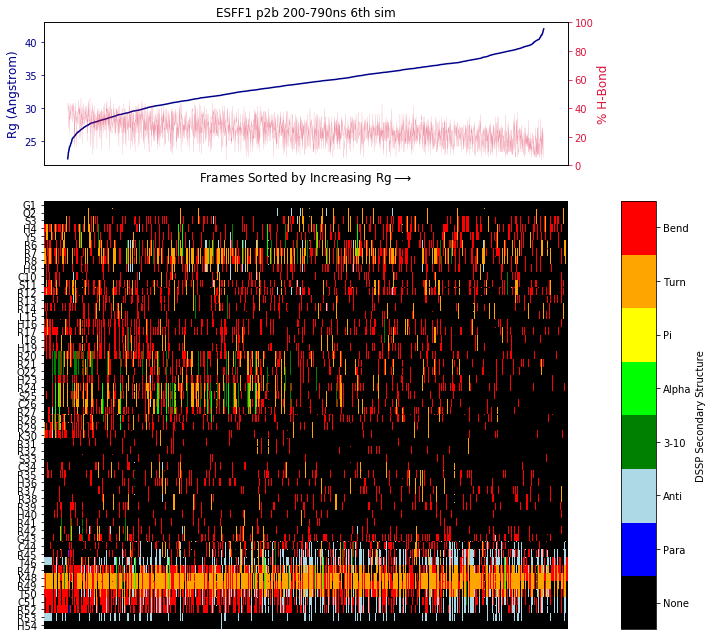

In [7]:
p2b_secstruc_sixth_newff=pd.read_csv("p2b_secstruct_sixth_newff.csv")
p2b_rg_newff=pd.read_csv('p2b_Rg_sixth_newff.csv')
frame_counts=p2b_secstruc_sixth_newff.Frames.max()
secstruc_bool=(p2b_secstruc_sixth_newff.Frames==frame_counts) 
p2b_secstruc_sixth_newff=p2b_secstruc_sixth_newff[~secstruc_bool]
temp_secstruc=p2b_secstruc_sixth_newff.Secstruct.values
temp_secstruc=temp_secstruc.reshape((int(temp_secstruc.shape[0]/54)),54)
temp_secstruc=pd.DataFrame(data=temp_secstruc,
                           columns=p2b_secstruc_sixth_newff.Residues.unique())
p2b_secstruc_sixth_newff=pd.concat([p2b_rg_newff.iloc[:,0],
                                        temp_secstruc],axis=1)
del temp_secstruc
p2b_ss_newff=ss_propensity(p2b_secstruc_sixth_newff)
fig,axs=plt.subplots(ncols=2,nrows=2,figsize=(10,9),
                     gridspec_kw={'width_ratios': [15, 1],
                                  'height_ratios':[1,3]})
p2b_heatmap=p2b_secstruc_sixth_newff.copy().iloc[::100,:]
p2b_heatmap['Rg']=p2b_rg_newff.iloc[::100,:].Rg.values
p2b_heatmap['total_ss']=p2b_ss_newff.values[::100]
p2b_heatmap=p2b_heatmap.sort_values(by=['Rg'],ascending=True)
axs[0,0].plot(p2b_heatmap.Rg.values, color='darkblue')
axs[0,0].set_ylabel('Rg (Angstrom)',color='darkblue',fontsize=12)
axs[0,0].tick_params(axis="y", colors="darkblue")
axs[0,0].tick_params(axis="x", bottom=False, labelbottom=False)
axs[0,0].set_xlabel('Frames Sorted by Increasing Rg'+ r'$\longrightarrow$',
                   fontsize=12)
axs[0,0].set_title('ESFF1 p2b 200-790ns 6th sim',
                   fontsize=12)
ax=axs[0,0].twinx()
ax.plot(p2b_heatmap.total_ss.values*100,color='crimson',alpha=0.5,
        linewidth=0.2)
ax.set_ylabel('% H-Bond', color='crimson',fontsize=12)
ax.tick_params(axis="y", colors="crimson")
ax.set_ylim(0,100)
sequence='GQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH'
sequence=[sequence[i-1]+str(i) for i in range(1,len(sequence)+1)]
sns.heatmap(p2b_heatmap.iloc[:,1:-2].T,ax=axs[1,0],
            xticklabels=False,yticklabels=True,
            cmap=ListedColormap(['black', 'blue','lightblue',
                                 'green','lime','yellow','orange','red']),
            cbar=False)
axs[1,0].set_yticklabels(sequence)
cmap = mpl.colors.ListedColormap(['black', 'blue','lightblue',
                                  'green','lime','yellow','orange','red'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [0, 1, 2, 3, 4, 5,6,7, 8.0]
ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = mpl.colorbar.ColorbarBase(axs[1,1], cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=ticks,
                                spacing='proportional',
                                orientation='vertical')
cbar.set_ticklabels(['None','Para','Anti','3-10','Alpha','Pi','Turn','Bend'])
cbar.set_label('DSSP Secondary Structure')
axs[0,1].remove()
plt.tight_layout()

In [2]:
p2b_rg=pd.read_csv("P2b_Rg_master_out.csv")
p2b_secstruc=pd.read_csv("P2b_master_secstruct.csv")
frame_counts=p2b_secstruc.groupby('sim').Frames.max()
for simm in frame_counts.index:
    secstruc_bool=(p2b_secstruc.sim==simm) & (p2b_secstruc.Frames==frame_counts[simm]) 
    p2b_secstruc=p2b_secstruc[~secstruc_bool]
temp_secstruc=p2b_secstruc.Secstruct.values
temp_secstruc=temp_secstruc.reshape((int(temp_secstruc.shape[0]/54)),54)
temp_secstruc=pd.DataFrame(data=temp_secstruc,columns=p2b_secstruc.Residues.unique())
p2b_secstruc=pd.concat([p2b_rg.iloc[:,:2],temp_secstruc],axis=1)
del temp_secstruc

In [3]:
p2b_rg=p2b_rg[p2b_rg.sim!=8]
p2b_secstruc=p2b_secstruc[p2b_secstruc.sim!=8]
p2b_rg=p2b_rg[p2b_rg.sim!=15]
p2b_secstruc=p2b_secstruc[p2b_secstruc.sim!=15]

CPU times: user 169 ms, sys: 20 ms, total: 189 ms
Wall time: 209 ms


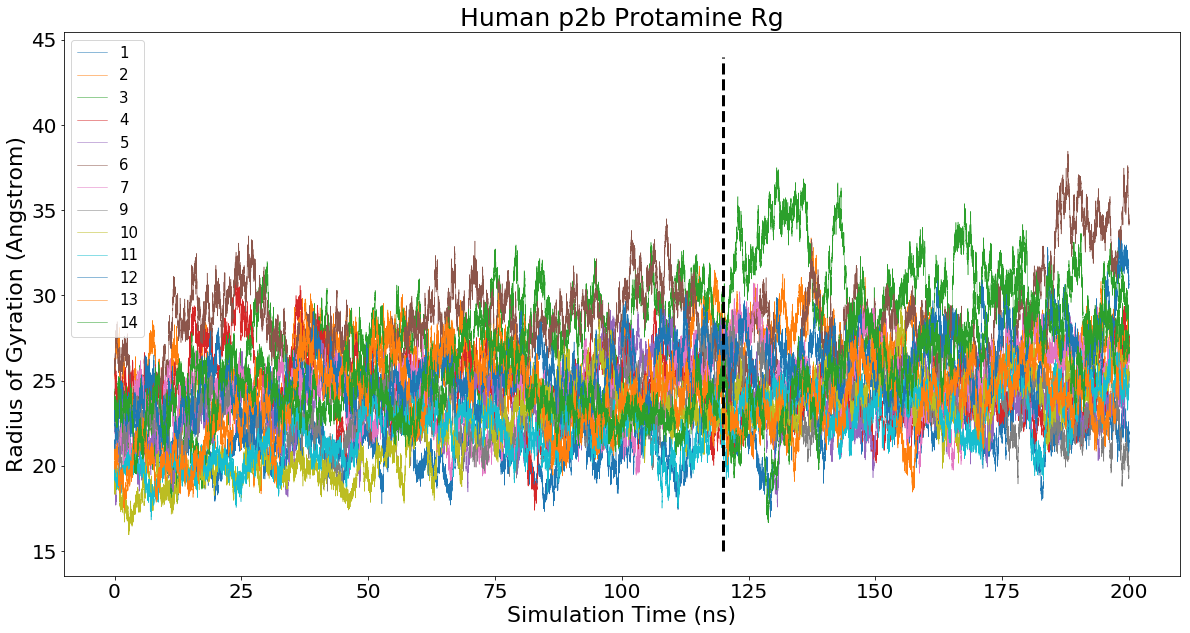

In [4]:
%%time
fig,ax = plt.subplots(figsize=(20,10))
temp_p2b=p2b_rg.copy()
for sim in temp_p2b.sim.unique():
    ax.plot(temp_p2b[temp_p2b.sim==sim].frames/500,
            temp_p2b[temp_p2b.sim==sim].Rg.values,label=str(sim),
            linewidth=0.5)
ax.legend(fontsize=15)
ax.set_title('Human p2b Protamine Rg',fontsize=25)
ax.set_xlabel('Simulation Time (ns)',fontsize=22)
ax.set_ylabel('Radius of Gyration (Angstrom)',fontsize=22)
#ax.set_xlim(0,201)
plt.setp(ax.get_yticklabels(), fontsize=20)
plt.setp(ax.get_xticklabels(), fontsize=20)
cutoff = 60000/500
ax.plot([cutoff,cutoff],[15,44],linewidth = 3, color='black',linestyle='dashed')
del temp_p2b

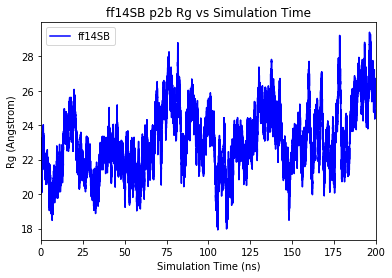

In [5]:
p2b_rg_singlesim=pd.read_csv("P2b_Rg_master_out.csv").iloc[:,:3]
p2b_rg_singlesim=p2b_rg_singlesim[p2b_rg_singlesim.sim!=8]
plt.plot(p2b_rg_singlesim[p2b_rg_singlesim.sim==15].frames.values/500,
         p2b_rg_singlesim[p2b_rg_singlesim.sim==15].Rg.values,color='blue',label='ff14SB')
plt.xlabel('Simulation Time (ns)')
plt.ylabel('Rg (Angstrom)')
plt.title('ff14SB p2b Rg vs Simulation Time')
plt.xlim(0,200)
plt.legend()

In [6]:
%%time
blank_df = pd.DataFrame()
for sim in p2b_rg.sim.unique():
    temp_df = p2b_rg[p2b_rg.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
p2b_rg = blank_df.copy()

blank_df = pd.DataFrame()
for sim in p2b_secstruc.sim.unique():
    temp_df = p2b_secstruc[p2b_secstruc.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
p2b_secstruc = blank_df.copy()

del blank_df
del temp_df

CPU times: user 692 ms, sys: 411 ms, total: 1.1 s
Wall time: 1.1 s


/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


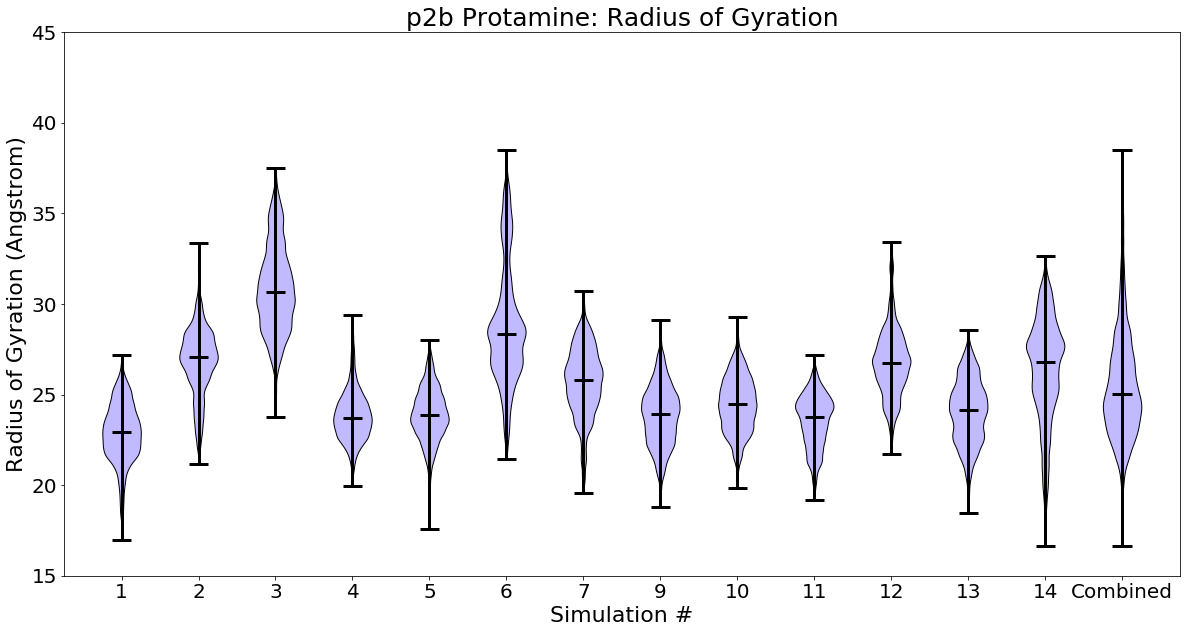

In [7]:
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels,fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Simulation #', fontsize=22)
data = []
labels=[]
fig,ax = plt.subplots(figsize=(20, 10))
for sim in p2b_rg.sim.unique():
    data.append(list(p2b_rg[p2b_rg.sim==sim].Rg.values))
    labels.append(str(sim))
data.append(p2b_rg.Rg.values)
labels.append('Combined')
ax.set_title('p2b Protamine: Radius of Gyration', fontsize=25)
ax.set_ylabel('Radius of Gyration (Angstrom)',fontsize=22)
ax.set_ylim(15,45)
#ax.violinplot(data)
parts = ax.violinplot(
        data, showmeans=False, showmedians=True,
        showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('#c2baff')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmedians'].set_color('black')
parts['cbars'].set_color('black')
parts['cmins'].set_color('black')
parts['cmaxes'].set_color('black')
parts['cmedians'].set_linewidth(3)
parts['cbars'].set_linewidth(3)
parts['cmins'].set_linewidth(3)
parts['cmaxes'].set_linewidth(3)
set_axis_style(ax,labels)

In [3]:
def calculate_helicity(df_secstruc):
    temp_secstruc=df_secstruc.iloc[:,2:]
    helix_tot=temp_secstruc.shape[1]
    temp_3_10=temp_secstruc.eq(3).sum(axis=1)
    temp_alpha=temp_secstruc.eq(4).sum(axis=1)
    temp_pi=temp_secstruc.eq(5).sum(axis=1)
    helic_frac=(temp_3_10+temp_alpha+temp_pi)/helix_tot
    return helic_frac
def calculate_helicity_byres(df_secstruc):
    temp_secstruc=df_secstruc.iloc[:,2:]
    helix_tot=temp_secstruc.shape[0]
    temp_3_10=temp_secstruc.eq(3).sum(axis=0)
    temp_alpha=temp_secstruc.eq(4).sum(axis=0)
    temp_pi=temp_secstruc.eq(5).sum(axis=0)
    helic_frac_byres=(temp_3_10+temp_alpha+temp_pi)/helix_tot
    return helic_frac_byres
def ss_propensity(df_secstruc):
    temp_secstruc=df_secstruc.iloc[:,2:]
    ss_tot=temp_secstruc.shape[1]
    ss=temp_secstruc.ne(0).sum(axis=1)
    ss_frac=ss/ss_tot
    return ss_frac

In [9]:
def calculate_helicity_aa(df_secstruc,aa_sequence):
    temp_secstruc=df_secstruc.iloc[:,2:]
    helix_tot=temp_secstruc.shape[0]
    temp_3_10=temp_secstruc.eq(3).sum(axis=0)
    temp_alpha=temp_secstruc.eq(4).sum(axis=0)
    temp_pi=temp_secstruc.eq(5).sum(axis=0)
    helicity_total=(temp_3_10+temp_alpha+temp_pi)/helix_tot
    byaa_helicity=pd.DataFrame(data=helicity_total)
    aa_sequence=[aa_sequence[i-1] for i in range(1,len(aa_sequence)+1)]
    byaa_helicity['sequence']=aa_sequence
    byaa_helicity.columns=['helicity','sequence']
    aa_list=byaa_helicity.sequence.unique()
    protamine_helicity_aa=[]
    aa_count=[]
    aa_id=[]
    helicity_error=[]
    for i in aa_list:
        aa_id.append(i)
        protamine_helicity_aa.append(sum(byaa_helicity[byaa_helicity.sequence==i].helicity.values))
        helicity_error.append(byaa_helicity[byaa_helicity.sequence==i].helicity.values.std())
        aa_count.append(byaa_helicity[byaa_helicity.sequence==i].shape[0])   
    helicity_by_aa=[float(i)/float(j) for i,j in zip(protamine_helicity_aa,aa_count)]
    #helicity_by_aa=protamine_helicity_aa
    return [aa_id,helicity_by_aa,helicity_error]

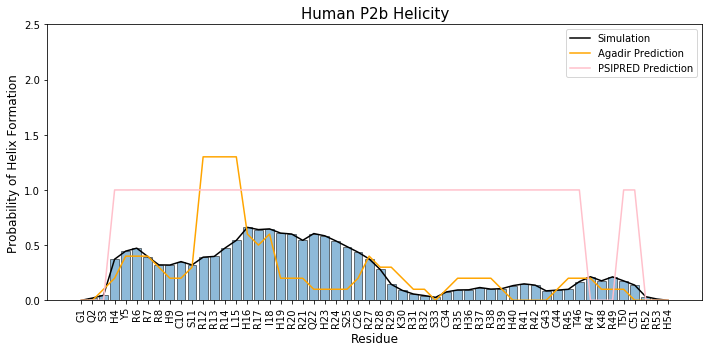

In [10]:
#PSIPRED is just presence or absence of helix
fig,ax=plt.subplots(figsize=(10,5))
byres_helix= calculate_helicity_byres(p2b_secstruc)
byres_helix=pd.DataFrame(data=byres_helix)
ax.plot(byres_helix,color='black', label='Simulation');
agadir=[0,0,0.1,0.2,0.4,0.4,0.4,0.3,0.2,0.2,0.3,1.3,1.3,1.3,1.3,
        0.6,0.5,0.6,0.2,0.2,0.2,0.1,0.1,0.1,0.1,0.2,0.4,0.3,0.3,0.2,
        0.1,0.1,0,0.1,0.2,0.2,0.2,0.2,0.1,0,0,0,0,0.1,0.2,0.2,
        0.2,0.1,0.1,0.1,0,0,0,0]
psipred=[0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,0,0,0]
ax.plot(byres_helix.index,agadir,color='orange',label='Agadir Prediction');
ax.plot(byres_helix.index,psipred,color='pink',label='PSIPRED Prediction');
ax.bar(np.arange(1,byres_helix.values.size+1),
        byres_helix.iloc[:,0].values,
       alpha=0.5,edgecolor='black')
ax.set_ylabel('Probability of Helix Formation',fontsize=12)
ax.set_title('Human P2b Helicity', fontsize=15)
ax.set_ylim(0,2.5)
ax.set_xlabel('Residue',fontsize=12)
sequence='GQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH'
sequence=[sequence[i-1]+str(i) for i in range(1,len(sequence)+1)]
ax.set_xticks(np.arange(1,byres_helix.values.size+1))
ax.set_xticklabels(sequence,rotation=90);
ax.legend()
plt.tight_layout()

TypeError: set_xticklabels() missing 1 required positional argument: 'labels'

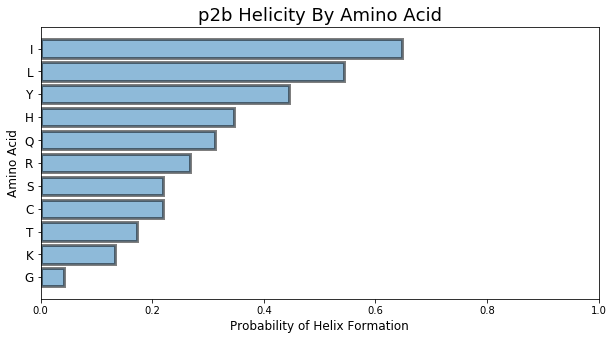

In [11]:
p2b_aa='GQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH'
p2b_aa_id=calculate_helicity_aa(p2b_secstruc,p2b_aa)[0]
p2b_aa_helicity=calculate_helicity_aa(p2b_secstruc,p2b_aa)[1]
p2b_aa=pd.DataFrame()
p2b_aa['id']=p2b_aa_id
p2b_aa['helicity']=p2b_aa_helicity
p2b_aa=p2b_aa.sort_values(by=['helicity'],ascending=True)
#error=calculate_helicity_aa(p2b_secstruc,p2b_aa)[2]
fig,ax=plt.subplots(figsize=(10,5))
#ax.plot(p2b_aa_helicity,color='black');
ax.barh(np.arange(1,p2b_aa.helicity.values.size+1),
        p2b_aa.helicity.values,
       alpha=0.5,edgecolor='black', linewidth=3)
ax.set_xlabel('Probability of Helix Formation',fontsize=12)
ax.set_title('p2b Helicity By Amino Acid', fontsize=18)
ax.set_xlim(0,1)
ax.set_ylabel('Amino Acid',fontsize=12)
ax.set_yticks(np.arange(1,p2b_aa.helicity.values.size+1))
ax.set_yticklabels(p2b_aa.id, size=12);
ax.set_xticklabels(size=12)
plt.tight_layout()

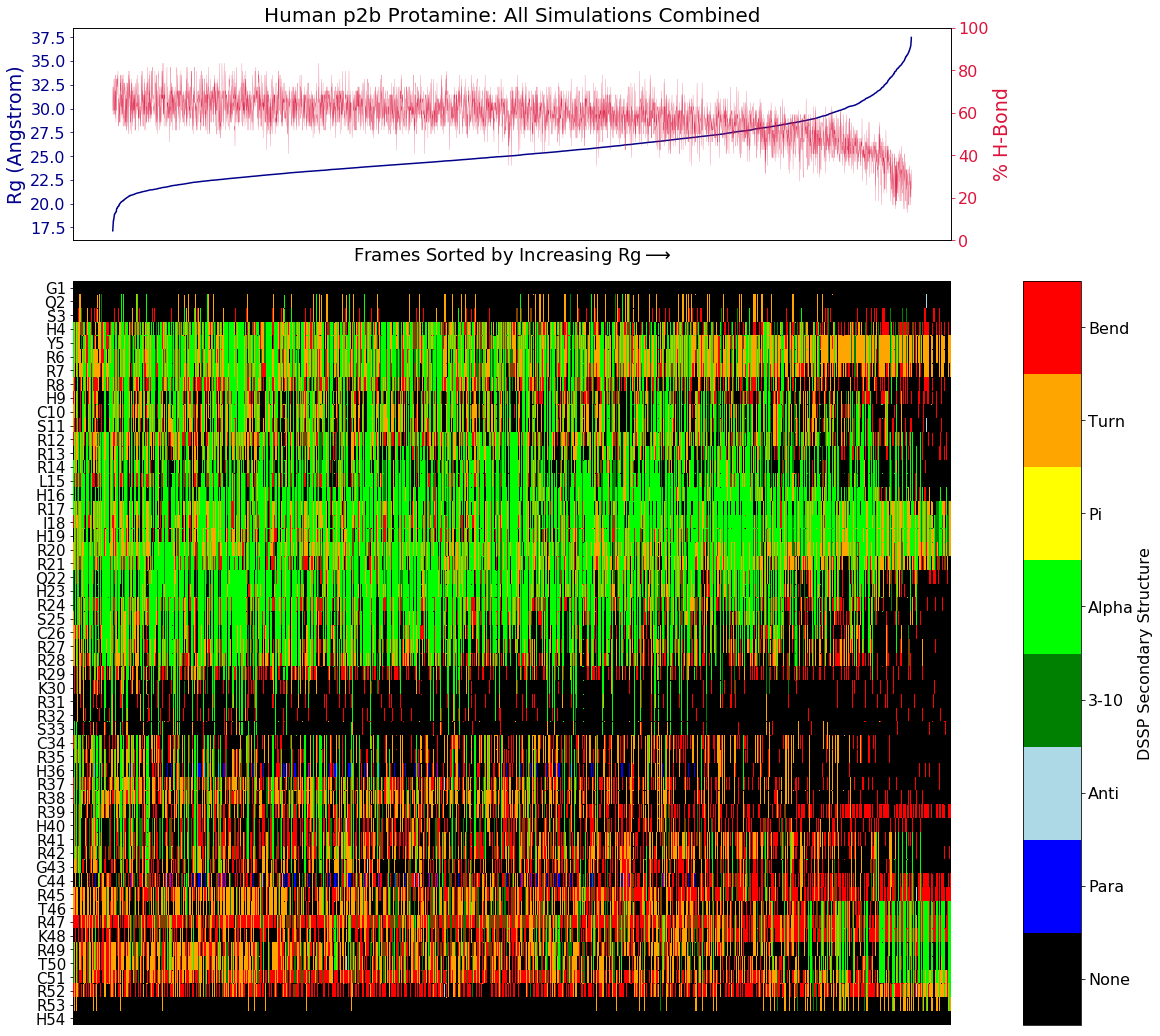

In [12]:
ss=ss_propensity(p2b_secstruc)
fig,axs=plt.subplots(ncols=2,nrows=2,figsize=(16,14.5),
                     gridspec_kw={'width_ratios': [15, 1],
                                  'height_ratios':[1,3.5]})
p2b_heatmap=p2b_secstruc.copy().iloc[::100,:]
p2b_heatmap['Rg']=p2b_rg.iloc[::100,:].Rg.values
p2b_heatmap['total_ss']=ss.values[::100]
p2b_heatmap=p2b_heatmap.sort_values(by=['Rg'],ascending=True)
axs[0,0].plot(p2b_heatmap.Rg.values, color='darkblue',linewidth=1.5)
axs[0,0].set_ylabel('Rg (Angstrom)',color='darkblue',fontsize=19)
axs[0,0].tick_params(axis="y", colors="darkblue")
axs[0,0].tick_params(axis="x", bottom=False, labelbottom=False)
plt.setp(axs[0,0].get_yticklabels(), fontsize=16)
axs[0,0].set_xlabel('Frames Sorted by Increasing Rg'+ r'$\longrightarrow$',
                   fontsize=18)
axs[0,0].set_title('Human p2b Protamine: All Simulations Combined',
                   fontsize=20)
ax=axs[0,0].twinx()
ax.plot(p2b_heatmap.total_ss.values*100,color='crimson',alpha=0.9,
        linewidth=0.2)
ax.set_ylabel('% H-Bond', color='crimson',fontsize=19)
plt.setp(ax.get_yticklabels(), fontsize=16)
ax.tick_params(axis="y", colors="crimson")
ax.set_ylim(0,100)
sequence='GQSHYRRRHCSRRRLHRIHRRQHRSCRRRKRRSCRHRRRHRRGCRTRKRTCRRH'
sequence=[sequence[i-1]+str(i) for i in range(1,len(sequence)+1)]
sns.heatmap(p2b_heatmap.iloc[:,2:-2].T,ax=axs[1,0],
            xticklabels=False,yticklabels=True,
            cmap=ListedColormap(['black', 'blue','lightblue',
                                 'green','lime','yellow','orange','red']),
            cbar=False)
axs[1,0].set_yticklabels(sequence,fontsize=15)
cmap = mpl.colors.ListedColormap(['black', 'blue','lightblue',
                                  'green','lime','yellow','orange','red'])
cmap.set_over('0.25')
cmap.set_under('0.75')

bounds = [0, 1, 2, 3, 4, 5,6,7, 8]
ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cbar = mpl.colorbar.ColorbarBase(axs[1,1], cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=ticks,
                                spacing='proportional',
                                orientation='vertical')
cbar.set_ticklabels(['None','Para','Anti','3-10','Alpha','Pi','Turn','Bend'])
cbar.set_label('DSSP Secondary Structure',size=16)
plt.setp(axs[1,1].get_yticklabels(), fontsize=16)
axs[0,1].remove()
plt.tight_layout()

In [45]:
#import pytraj as pt
p2b_traj=p2b_secstruc.copy().iloc[::100,:]
p2b_traj['Rg']=p2b_rg.iloc[::100,:].Rg.values
p2b_traj['total_ss']=ss.values[::100]
p2b_traj=p2b_traj.sort_values(by=['Rg'],ascending=True)
sims=['first','second','third','fourth','fifth','sixth','seventh','eighth',
      'ninth','tenth','eleventh','twelfth','thirteenth','fourteenth',
      'fifteenth']
p2b_traj.to_csv('p2b_traj.csv',index=False)

/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


([<matplotlib.axis.YTick at 0x2aab24c99400>,
 <a list of 54 Text yticklabel objects>)

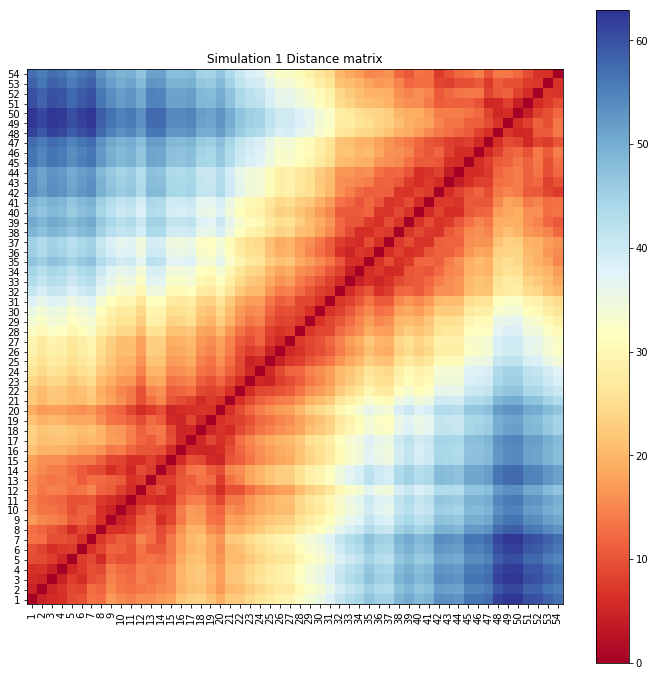

In [13]:
#means distance matrix 
fig,axs=plt.subplots(ncols=1,nrows=1,figsize=(12,12))
#,  gridspec_kw={'width_ratios': [15, 1],
 #       'height_ratios':[1,3]})
p2b_dist_mat_means=pd.read_csv("p2b_pairwise_dist_means.csv")
#p2b_dist_mat_stdev=pd.read_csv("p2b_pairwise_dist_stdev.csv")
sim=1
p2b_res1=p2b_dist_mat_means[p2b_dist_mat_means.sim==sim]['res1']
p2b_temp_means=p2b_dist_mat_means[p2b_dist_mat_means.sim==sim].iloc[:,2:]
p2b_temp_means=p2b_temp_means.set_index(p2b_res1.values)
p2b_temp_means.values[[np.arange(p2b_temp_means.shape[0])]*2] = 0
p2b_temp_means=p2b_temp_means.sort_index(ascending=False)
plt.imshow(p2b_temp_means,cmap="RdYlBu")
plt.colorbar()
plt.xticks(range(len(p2b_temp_means)),p2b_temp_means.columns,rotation=90)
plt.title('Simulation '+str(sim)+' Distance matrix')
plt.yticks(range(len(p2b_temp_means)),p2b_temp_means.index)
#del p2b_temp_means
#del p2b_dist_mat_means

/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


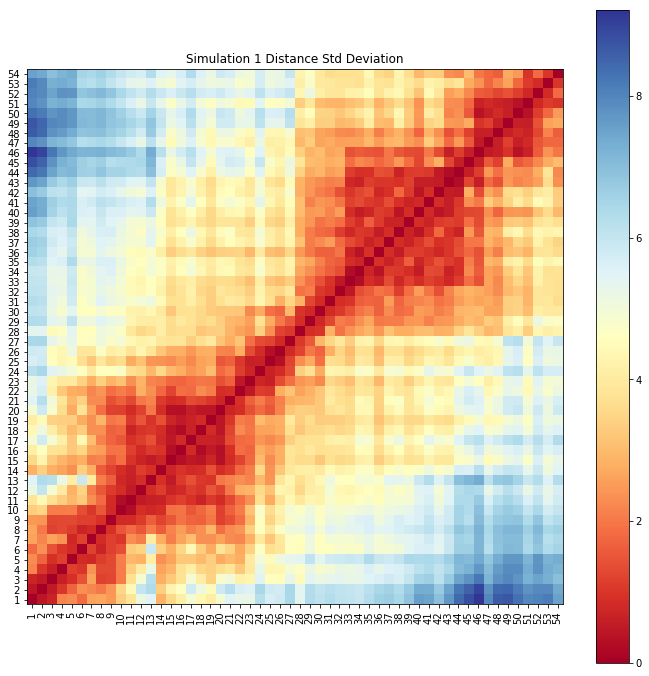

In [14]:
#means distance matrix stddeviation
fig,axs=plt.subplots(ncols=1,nrows=1,figsize=(12,12))
#,  gridspec_kw={'width_ratios': [15, 1],
 #       'height_ratios':[1,3]})
#p2b_dist_mat_means=pd.read_csv("p2b_pairwise_dist_means.csv")
p2b_dist_mat_stdev=pd.read_csv("p2b_pairwise_dist_stdev.csv")
sim=1
p2b_res1=p2b_dist_mat_stdev[p2b_dist_mat_stdev.sim==sim]['res1']
p2b_temp_stdev=p2b_dist_mat_stdev[p2b_dist_mat_stdev.sim==sim].iloc[:,2:]
p2b_temp_stdev=p2b_temp_stdev.set_index(p2b_res1.values)
p2b_temp_stdev.values[[np.arange(p2b_temp_stdev.shape[0])]*2] = 0
p2b_temp_stdev=p2b_temp_stdev.sort_index(ascending=False)
plt.imshow(p2b_temp_stdev,cmap="RdYlBu")
plt.colorbar()
plt.xticks(range(len(p2b_temp_stdev)),p2b_temp_stdev.columns,rotation=90)
plt.title('Simulation '+str(sim)+' Distance Std Deviation')
plt.yticks(range(len(p2b_temp_stdev)),p2b_temp_stdev.index)
del p2b_temp_stdev
del p2b_dist_mat_stdev

/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


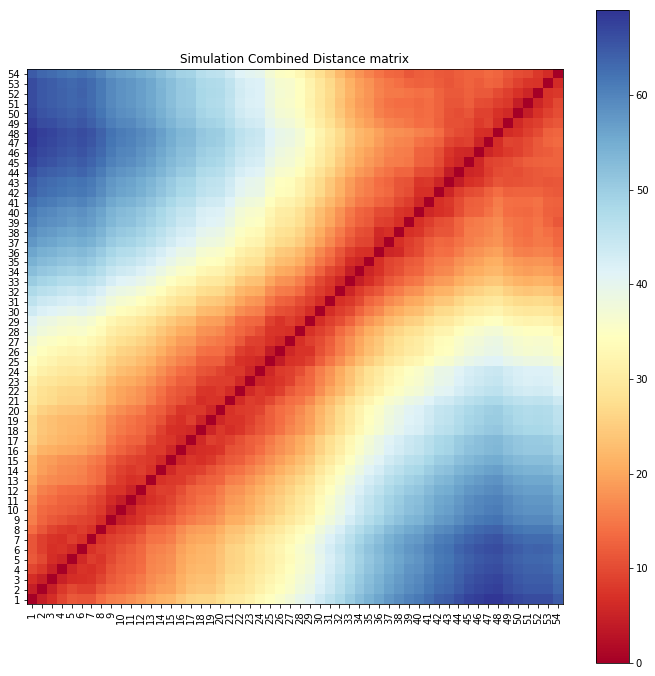

In [15]:
#means distance matrix 
fig,axs=plt.subplots(ncols=1,nrows=1,figsize=(12,12))
#,  gridspec_kw={'width_ratios': [15, 1],
 #       'height_ratios':[1,3]})
p2b_dist_mat_means=pd.read_csv("p2b_pairwise_dist_means_allsims.csv")
#p2b_dist_mat_stdev=pd.read_csv("p2b_pairwise_dist_stdev.csv")
p2b_res1=p2b_dist_mat_means['res1']
p2b_temp_means=p2b_dist_mat_means.iloc[:,1:]
p2b_temp_means=p2b_temp_means.set_index(p2b_res1.values)
p2b_temp_means.values[[np.arange(p2b_temp_means.shape[0])]*2] = 0
p2b_temp_means=p2b_temp_means.sort_index(ascending=False)
plt.imshow(p2b_temp_means,cmap="RdYlBu")
plt.colorbar()
plt.xticks(range(len(p2b_temp_means)),p2b_temp_means.columns,rotation=90)
plt.title('Simulation Combined Distance matrix')
plt.yticks(range(len(p2b_temp_means)),p2b_temp_means.index)
del p2b_temp_means
del p2b_dist_mat_means

/public/apps/python/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


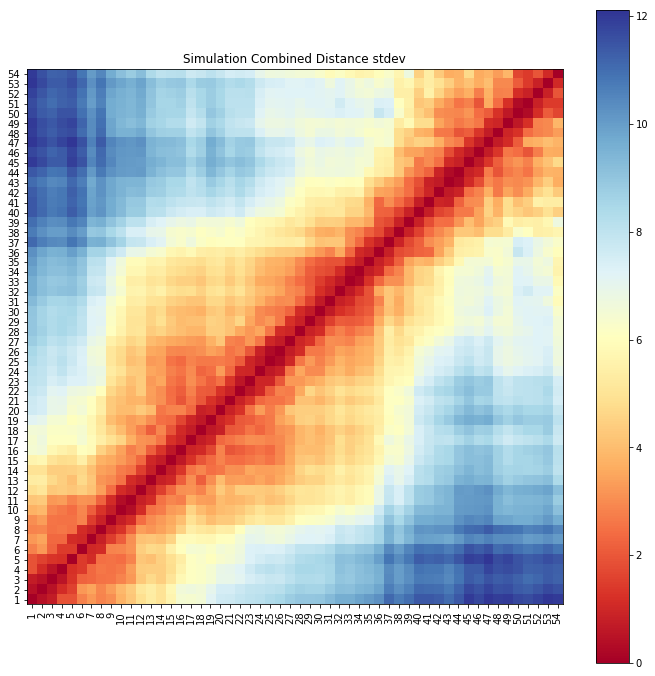

In [16]:
# distance matrix  stdev
fig,axs=plt.subplots(ncols=1,nrows=1,figsize=(12,12))
#,  gridspec_kw={'width_ratios': [15, 1],
 #       'height_ratios':[1,3]})
p2b_dist_mat_stdev=pd.read_csv("p2b_pairwise_dist_stdev_allsims.csv")
#p2b_dist_mat_stdev=pd.read_csv("p2b_pairwise_dist_stdev.csv")
p2b_res1=p2b_dist_mat_stdev['res1']
p2b_temp_stdev=p2b_dist_mat_stdev.iloc[:,1:]
p2b_temp_stdev=p2b_temp_stdev.set_index(p2b_res1.values)
p2b_temp_stdev.values[[np.arange(p2b_temp_stdev.shape[0])]*2] = 0
p2b_temp_stdev=p2b_temp_stdev.sort_index(ascending=False)
plt.imshow(p2b_temp_stdev,cmap="RdYlBu")
plt.colorbar()
plt.xticks(range(len(p2b_temp_stdev)),p2b_temp_stdev.columns,rotation=90)
plt.title('Simulation Combined Distance stdev')
plt.yticks(range(len(p2b_temp_stdev)),p2b_temp_stdev.index)
del p2b_temp_stdev
del p2b_dist_mat_stdev

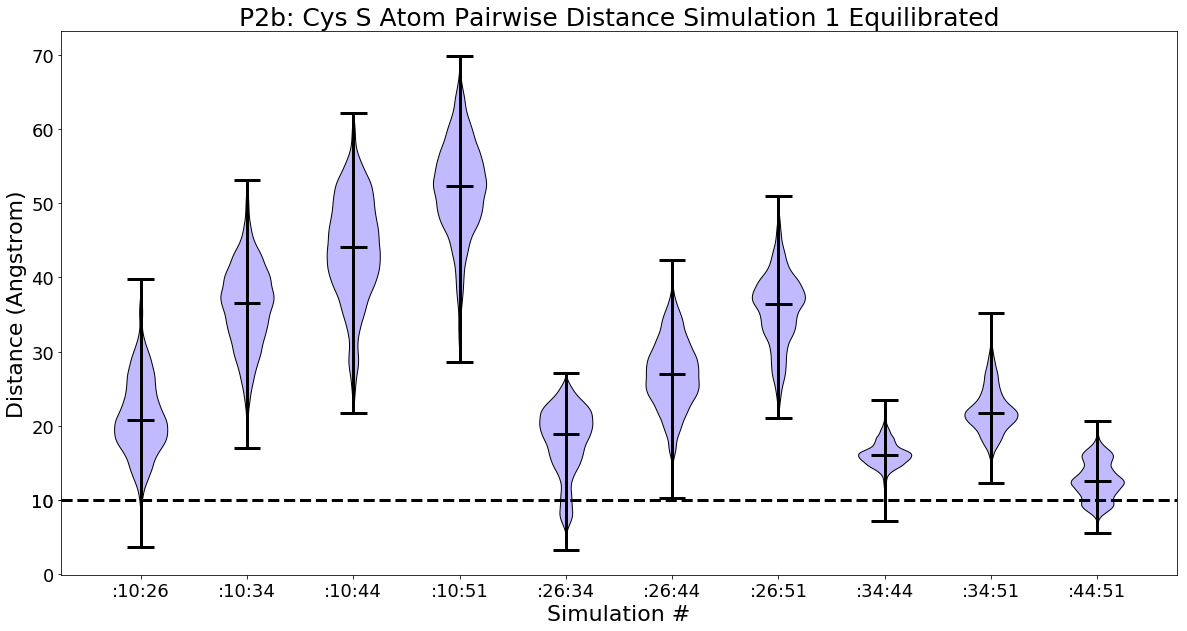

In [17]:
#disulfide bond check
#distance for each cysteine pair (sulfur atom to sulfur atom)
#this code takes equilibrated simulation time
#careful because sims 8 and 15 have to be disregarded for P2b
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels,fontsize=18)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Simulation #', fontsize=22)
data = []
labels=[]
fig,ax = plt.subplots(figsize=(20, 10))
temp_p2b=pd.read_csv("p2b_cys_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b.sim.unique():
    temp_df = temp_p2b[temp_p2b.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b = blank_df.copy()
del temp_df
del blank_df
sim=1
for pair in temp_p2b.iloc[:,2:].columns:
    data.append(list(temp_p2b[temp_p2b.sim==sim][pair].values))
    labels.append(str(pair))
ax.set_title('P2b: Cys S Atom Pairwise Distance Simulation '+str(sim)+' Equilibrated',
             fontsize=25)
ax.set_ylabel('Distance (Angstrom)',fontsize=22)
#ax.set_ylim(11,37)
#ax.violinplot(data)
parts = ax.violinplot(
        data, showmeans=False, showmedians=True,
        showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('#c2baff')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmedians'].set_color('black')
parts['cbars'].set_color('black')
parts['cmins'].set_color('black')
parts['cmaxes'].set_color('black')
parts['cmedians'].set_linewidth(3)
parts['cbars'].set_linewidth(3)
parts['cmins'].set_linewidth(3)
parts['cmaxes'].set_linewidth(3)
set_axis_style(ax,labels)
plt.axhline(y=10,linewidth = 3, color='black',linestyle='dashed',label='10')
#ax.annotate('10 Angstrom',xy=(2,10),fontsize=20)
#plt.xticks(np.arange(0,20,10)+)
extraticks=[10]
lim = ax.get_ylim()
ax.set_yticks(list(ax.get_yticks()) + extraticks)
ax.set_ylim(lim)
del temp_p2b

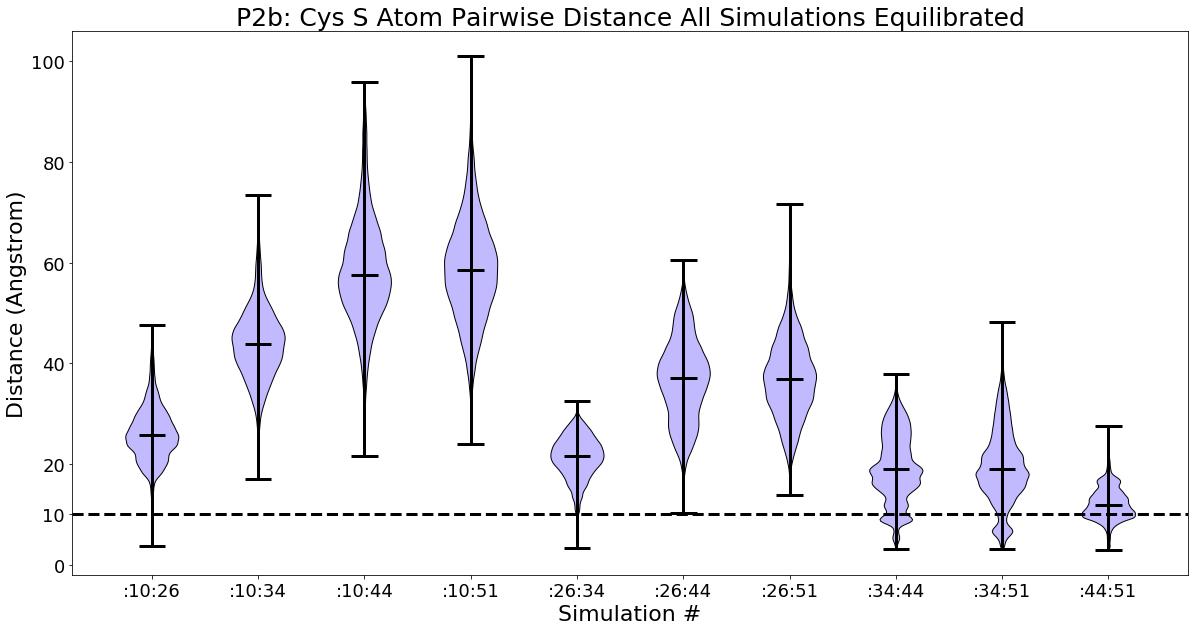

In [18]:
#disulfide bond check
#distance for each cysteine pair (sulfur atom to sulfur atom)
#this code takes equilibrated simulation time
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels,fontsize=18)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Simulation #', fontsize=22)
data = []
labels=[]
fig,ax = plt.subplots(figsize=(20, 10))
temp_p2b=pd.read_csv("p2b_cys_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b.sim.unique():
    temp_df = temp_p2b[temp_p2b.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b = blank_df.copy()
del temp_df
del blank_df
temp_p2b=temp_p2b[temp_p2b.sim!=8]
temp_p2b=temp_p2b[temp_p2b.sim!=15]
for pair in temp_p2b.iloc[:,2:].columns:
    data.append(list(temp_p2b[pair].values))
    labels.append(str(pair))
ax.set_title('P2b: Cys S Atom Pairwise Distance All Simulations Equilibrated',
             fontsize=25)
ax.set_ylabel('Distance (Angstrom)',fontsize=22)
#ax.set_ylim(11,37)
#ax.violinplot(data)
parts = ax.violinplot(
        data, showmeans=False, showmedians=True,
        showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('#c2baff')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmedians'].set_color('black')
parts['cbars'].set_color('black')
parts['cmins'].set_color('black')
parts['cmaxes'].set_color('black')
parts['cmedians'].set_linewidth(3)
parts['cbars'].set_linewidth(3)
parts['cmins'].set_linewidth(3)
parts['cmaxes'].set_linewidth(3)
set_axis_style(ax,labels)
plt.axhline(y=10,linewidth = 3, color='black',linestyle='dashed',label='10')
#ax.annotate('10 Angstrom',xy=(2,10),fontsize=20)
#plt.xticks(np.arange(0,20,10)+)
extraticks=[10]
lim = ax.get_ylim()
ax.set_yticks(list(ax.get_yticks()) + extraticks)
ax.set_ylim(lim)
del temp_p2b

/public/apps/python/3.7.0/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


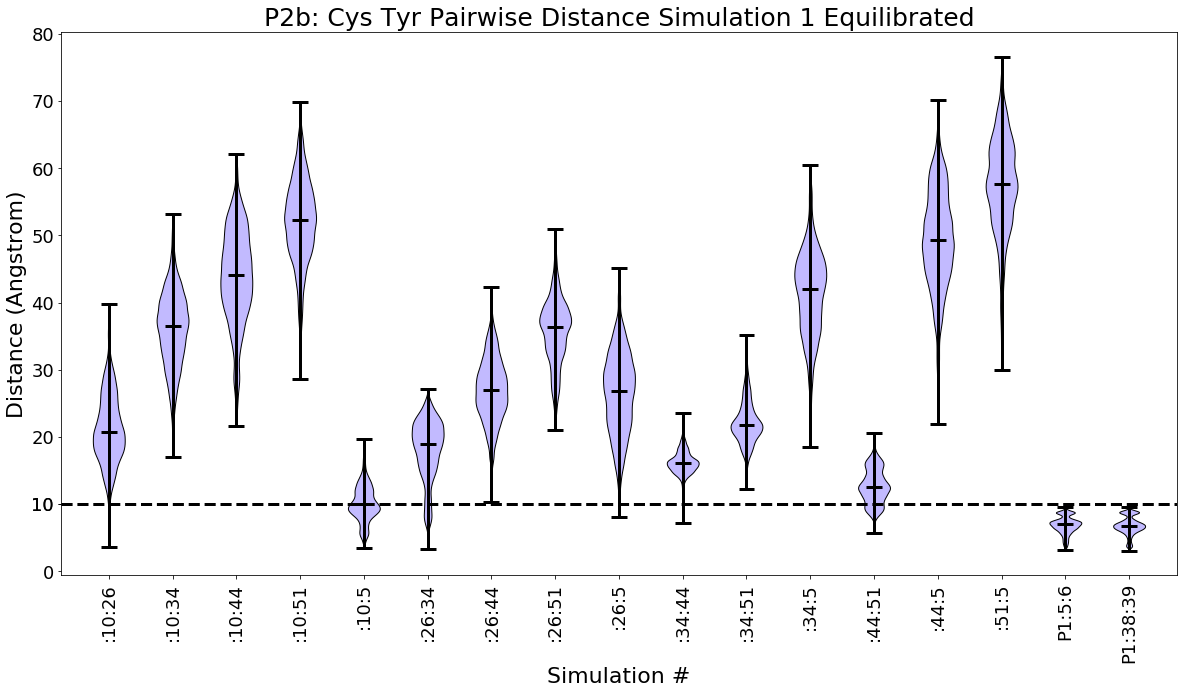

In [20]:
#disulfide bond check
#distance for each cysteine pair (sulfur atom to sulfur atom)
#this code takes equilibrated simulation time
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels,fontsize=18,rotation=90)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Simulation #', fontsize=22)
data = []
labels=[]
fig,ax = plt.subplots(figsize=(20, 10))
temp_p2b=pd.read_csv("p2b_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b.sim.unique():
    temp_df = temp_p2b[temp_p2b.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b = blank_df.copy()
del temp_df
del blank_df
temp_p2b=temp_p2b[temp_p2b.sim!=8]
temp_p2b=temp_p2b[temp_p2b.sim!=15]
temp_p1=pd.read_csv("p1_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p1.sim.unique():
    temp_df = temp_p1[temp_p1.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p1 = blank_df.copy()
del temp_df
del blank_df
temp_p1=temp_p1[temp_p1.sim!=15]
temp_p1=temp_p1[temp_p1.sim!=13]
sim=1
for pair in temp_p2b.iloc[:,2:].columns:
    data.append(list(temp_p2b[temp_p2b.sim==sim][pair].values))
    labels.append(str(pair))
data.append(list(temp_p1[':5:6'].values))
labels.append('P1:5:6')
data.append(list(temp_p1[':38:39'].values))
labels.append('P1:38:39')
ax.set_title('P2b: Cys Tyr Pairwise Distance Simulation '+str(sim)+ ' Equilibrated',
             fontsize=25)
ax.set_ylabel('Distance (Angstrom)',fontsize=22)
#ax.set_ylim(11,37)
#ax.violinplot(data)
parts = ax.violinplot(
        data, showmeans=False, showmedians=True,
        showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('#c2baff')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmedians'].set_color('black')
parts['cbars'].set_color('black')
parts['cmins'].set_color('black')
parts['cmaxes'].set_color('black')
parts['cmedians'].set_linewidth(3)
parts['cbars'].set_linewidth(3)
parts['cmins'].set_linewidth(3)
parts['cmaxes'].set_linewidth(3)
set_axis_style(ax,labels)
plt.axhline(y=10,linewidth = 3, color='black',linestyle='dashed',label='10')
#ax.annotate('10 Angstrom',xy=(2,10),fontsize=20)
#plt.xticks(np.arange(0,20,10)+)
extraticks=[10]
lim = ax.get_ylim()
ax.set_yticks(list(ax.get_yticks()) + extraticks)
ax.set_ylim(lim)
del temp_p2b
del temp_p1

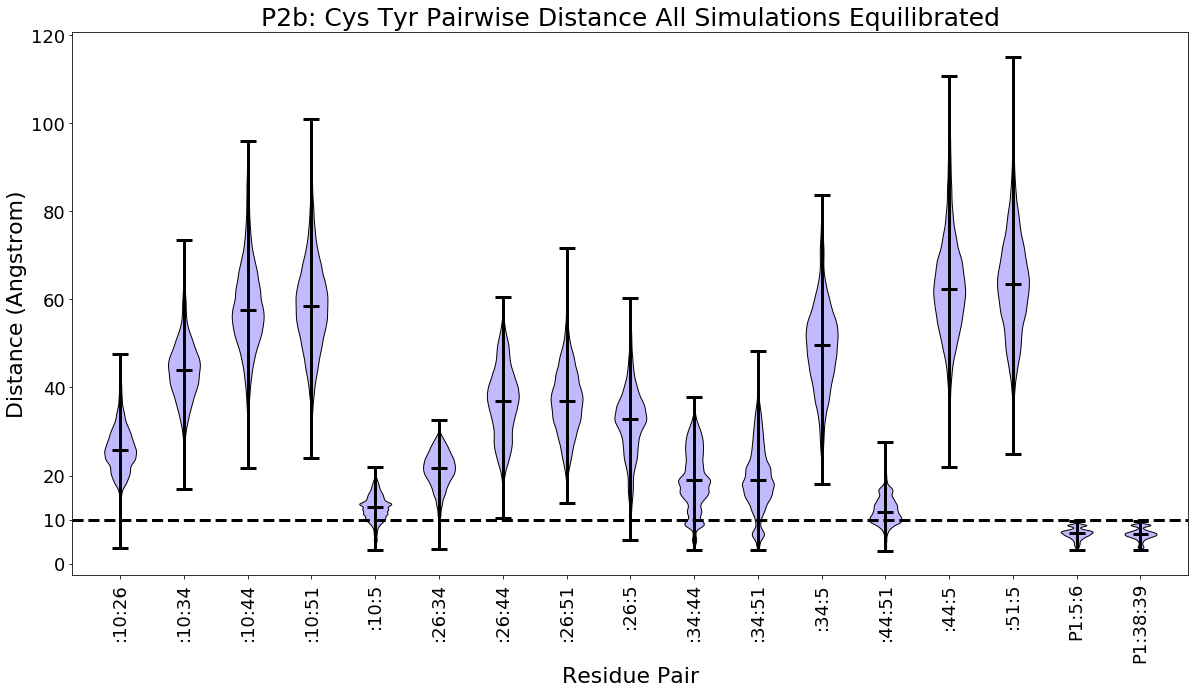

In [23]:
#disulfide bond check
#distance for each cysteine pair (sulfur atom to sulfur atom)
#this code takes equilibrated simulation time
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels,fontsize=18,rotation=90)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Residue Pair', fontsize=22)
data = []
labels=[]
fig,ax = plt.subplots(figsize=(20, 10))
temp_p2b=pd.read_csv("p2b_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b.sim.unique():
    temp_df = temp_p2b[temp_p2b.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b = blank_df.copy()
del temp_df
del blank_df
temp_p2b=temp_p2b[temp_p2b.sim!=8]
temp_p2b=temp_p2b[temp_p2b.sim!=15]
temp_p1=pd.read_csv("p1_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p1.sim.unique():
    temp_df = temp_p1[temp_p1.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p1 = blank_df.copy()
del temp_df
del blank_df
temp_p1=temp_p1[temp_p1.sim!=15]
temp_p1=temp_p1[temp_p1.sim!=13]
for pair in temp_p2b.iloc[:,2:].columns:
    data.append(list(temp_p2b[pair].values))
    labels.append(str(pair))
data.append(list(temp_p1[':5:6'].values))
labels.append('P1:5:6')
data.append(list(temp_p1[':38:39'].values))
labels.append('P1:38:39')
ax.set_title('P2b: Cys Tyr Pairwise Distance All Simulations Equilibrated',
             fontsize=25)
ax.set_ylabel('Distance (Angstrom)',fontsize=22)
#ax.set_ylim(11,37)
#ax.violinplot(data)
parts = ax.violinplot(
        data, showmeans=False, showmedians=True,
        showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('#c2baff')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmedians'].set_color('black')
parts['cbars'].set_color('black')
parts['cmins'].set_color('black')
parts['cmaxes'].set_color('black')
parts['cmedians'].set_linewidth(3)
parts['cbars'].set_linewidth(3)
parts['cmins'].set_linewidth(3)
parts['cmaxes'].set_linewidth(3)
set_axis_style(ax,labels)
plt.axhline(y=10,linewidth = 3, color='black',linestyle='dashed',label='10')
#ax.annotate('10 Angstrom',xy=(2,10),fontsize=20)
#plt.xticks(np.arange(0,20,10)+)
extraticks=[10]
lim = ax.get_ylim()
ax.set_yticks(list(ax.get_yticks()) + extraticks)
ax.set_ylim(lim)
del temp_p2b
del temp_p1

In [22]:
temp_p2b=pd.read_csv("p2b_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b.sim.unique():
    temp_df = temp_p2b[temp_p2b.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b = blank_df.copy()
del temp_df
del blank_df
temp_p2b=temp_p2b[temp_p2b.sim!=8]
temp_p2b=temp_p2b[temp_p2b.sim!=15]
temp_p1=pd.read_csv("p1_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p1.sim.unique():
    temp_df = temp_p1[temp_p1.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p1 = blank_df.copy()
del temp_df
del blank_df
temp_p1=temp_p1[temp_p1.sim!=15]
temp_p1=temp_p1[temp_p1.sim!=13]
#first goes through temp_p2b and finds consecutive pairs
consecutive_pairs=[]
for i in range(2,len(temp_p1.columns)):
    first=int(temp_p1.columns[i].split(':')[1])
    second=int(temp_p1.columns[i].split(':')[2])
    if second-first==1:
        consecutive_pairs.append(temp_p1.columns[i])
    elif first-second==1:
        consecutive_pairs.append(temp_p1.columns[i])
#next close_pairs contains non-consective pairs whose distances at least reach the same range as consective pair dist
close_pairs=[]
for i in range(2,len(temp_p2b.columns)):
    if temp_p2b[temp_p2b.columns[i]].values.min()<temp_p1[consecutive_pairs].values.max():
        close_pairs.append(temp_p2b.columns[i])
close_pairs_df=pd.DataFrame(data=close_pairs,columns=['pairs'])
close_pairs_df['number of simulations']=np.repeat(0,len(close_pairs_df))
#count number of simulations in which close pairs get close and update close_pairs_df
sims=[]
for sim in temp_p2b.sim.unique():
    closepairs_bysim=[]
    closepairs_bysim=temp_p2b[close_pairs].columns[temp_p2b[temp_p2b.sim==sim][close_pairs].min()<temp_p1[consecutive_pairs].values.max()] 
    if len(closepairs_bysim)!=0:
        close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysim),'number of simulations']=close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysim),'number of simulations']+1
del temp_p2b
del temp_p1
from tabulate import tabulate
print(tabulate(close_pairs_df, headers = 'keys', tablefmt = 'psql')) 

+----+---------+-------------------------+
|    | pairs   |   number of simulations |
|----+---------+-------------------------|
|  0 | :10:26  |                       4 |
|  1 | :10:5   |                      13 |
|  2 | :26:34  |                       5 |
|  3 | :26:5   |                       3 |
|  4 | :34:44  |                       8 |
|  5 | :34:51  |                       9 |
|  6 | :44:51  |                      12 |
+----+---------+-------------------------+


In [3]:
temp_p1=pd.read_csv("p1_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p1.sim.unique():
    temp_df = temp_p1[temp_p1.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p1 = blank_df.copy()
del temp_df
del blank_df
temp_p1=temp_p1[temp_p1.sim!=15]
temp_p1=temp_p1[temp_p1.sim!=13]
temp_p2b=pd.read_csv("p2b_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b.sim.unique():
    temp_df = temp_p2b[temp_p2b.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b = blank_df.copy()
del temp_df
del blank_df
temp_p2b=temp_p2b[temp_p2b.sim!=8]
temp_p2b=temp_p2b[temp_p2b.sim!=15]
consecutive_pairs=[]
for i in range(2,len(temp_p1.columns)):
    first=int(temp_p1.columns[i].split(':')[1])
    second=int(temp_p1.columns[i].split(':')[2])
    if second-first==1:
        consecutive_pairs.append(temp_p1.columns[i])
    elif first-second==1:
        consecutive_pairs.append(temp_p1.columns[i])
close_pairs=[]
for i in range(2,len(temp_p2b.columns)):
    if temp_p2b[temp_p2b.columns[i]].values.min()<temp_p1[consecutive_pairs].values.max() and temp_p2b.columns[i] not in consecutive_pairs:
        close_pairs.append(temp_p2b.columns[i])
close_pairs_df=pd.DataFrame(data=close_pairs,columns=['pairs'])
close_pairs_df['number of simulations']=np.repeat(0,len(close_pairs_df))
frac_cut=0.20
close_pairs_df['simtime>'+str(frac_cut)]=np.repeat(0,len(close_pairs_df))
#count number of simulations in which close pairs get close and update close_pairs_df
sims=[]
for sim in temp_p2b.sim.unique():
    closepairs_bysim=[]
    closepairs_bysim=temp_p2b[close_pairs].columns[temp_p2b[temp_p2b.sim==sim][close_pairs].min()<temp_p1[consecutive_pairs].values.max()]
    simtime=len(temp_p2b[temp_p2b.sim==sim][close_pairs])
    pairs_time=temp_p2b[temp_p2b.sim==sim][close_pairs][temp_p2b[temp_p2b.sim==sim][close_pairs]<temp_p1[consecutive_pairs].values.max()]
    simtime_frac=(simtime-pairs_time.isna().sum())/simtime
    closepairs_bysimtime=temp_p2b[close_pairs].columns[simtime_frac>=frac_cut]
    if len(closepairs_bysim)!=0:
        close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysim),'number of simulations']=close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysim),'number of simulations']+1
        close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysimtime),'simtime>'+str(frac_cut)]=close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysimtime),'simtime>'+str(frac_cut)]+1
del temp_p2b
del temp_p1
from tabulate import tabulate
print(tabulate(close_pairs_df, headers = 'keys', tablefmt = 'psql'))

+----+---------+-------------------------+---------------+
|    | pairs   |   number of simulations |   simtime>0.2 |
|----+---------+-------------------------+---------------|
|  0 | :10:26  |                       4 |             0 |
|  1 | :10:5   |                      13 |             2 |
|  2 | :26:34  |                       5 |             0 |
|  3 | :26:5   |                       3 |             0 |
|  4 | :34:44  |                       8 |             2 |
|  5 | :34:51  |                       9 |             1 |
|  6 | :44:51  |                      12 |             6 |
+----+---------+-------------------------+---------------+


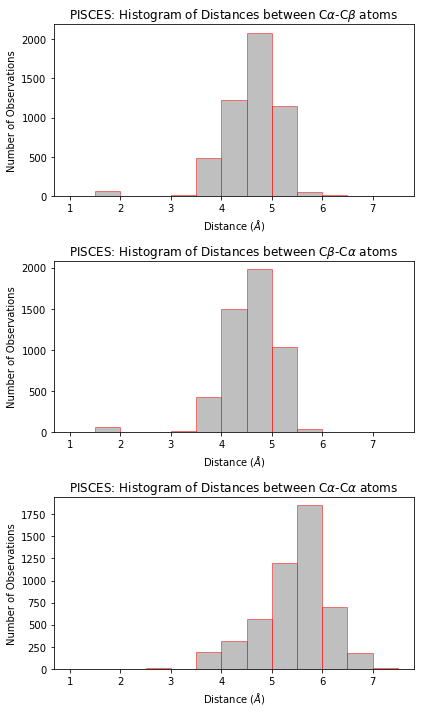

In [2]:
#using PISCES dataset, gao paper 'prediction of disulfide bond ....'
fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(6,10))
positive_distance_map_gao_paper = np.load('positive_distance_map.npy')
positive_calpha_cbeta_hist=ax[0].hist(positive_distance_map_gao_paper[:,6,4],
                    bins=np.arange(1,8,0.5),color='grey',
                    label='C alpha distance',alpha=0.5,
                edgecolor='red')
ax[0].set_xlabel('Distance'+ ' ('+r'$\AA$'+')')
ax[0].set_ylabel('Number of Observations')
ax[0].set_title('PISCES: Histogram of Distances between C'+r'$\alpha$'+'-C'+r'$\beta$'+ ' atoms')
positive_cbeta_calpha_hist=ax[1].hist(positive_distance_map_gao_paper[:,9,1],
                    bins=np.arange(1,8,0.5),color='grey',
                    label='C alpha distance',alpha=0.5,
                edgecolor='red')
ax[1].set_xlabel('Distance'+ ' ('+r'$\AA$'+')')
ax[1].set_ylabel('Number of Observations')
ax[1].set_title('PISCES: Histogram of Distances between C'+r'$\beta$'+'-C'+r'$\alpha$'+ ' atoms')
positive_cbeta_calpha_hist=ax[2].hist(positive_distance_map_gao_paper[:,6,1],
                    bins=np.arange(1,8,0.5),color='grey',
                    label='C alpha distance',alpha=0.5,
                edgecolor='red')
ax[2].set_xlabel('Distance'+ ' ('+r'$\AA$'+')')
ax[2].set_ylabel('Number of Observations')
ax[2].set_title('PISCES: Histogram of Distances between C'+r'$\alpha$'+'-C'+r'$\alpha$'+ ' atoms')
plt.tight_layout()

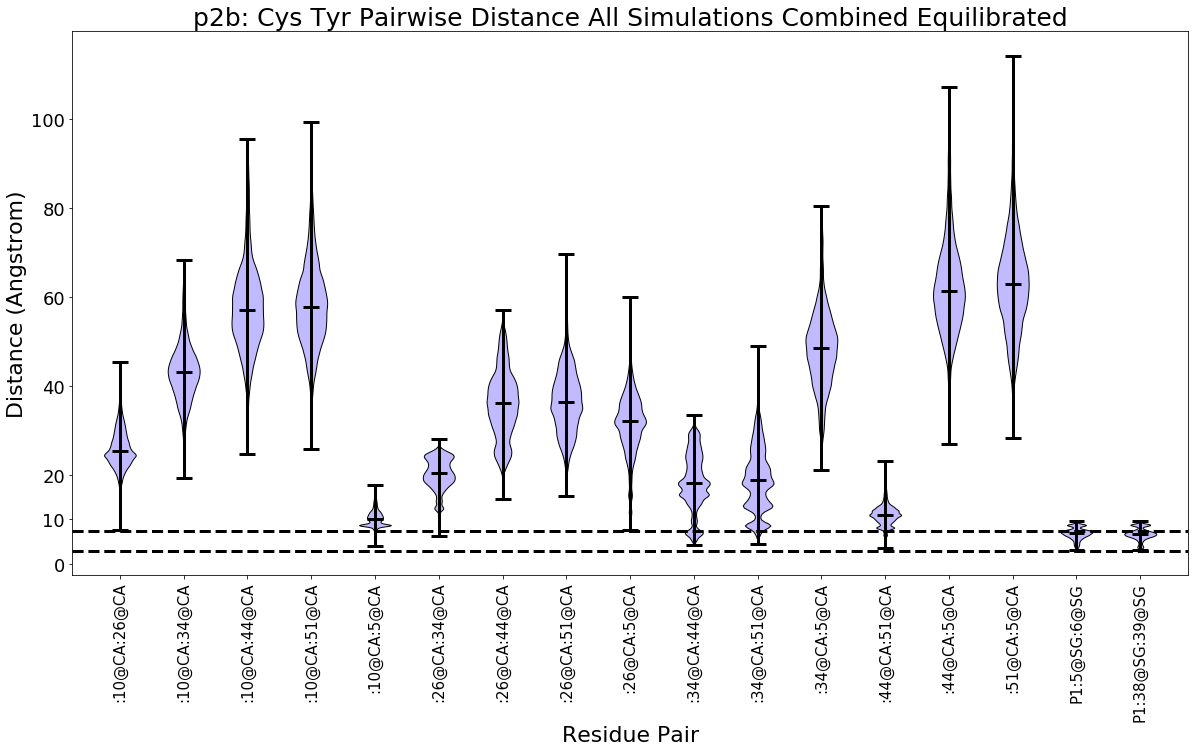

In [2]:
#disulfide bond check
#based on disulfide bond paper
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels,fontsize=15,rotation=90)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Residue Pair', fontsize=22)
data = []
labels=[]
fig,ax = plt.subplots(figsize=(20, 10))
temp_p1=pd.read_csv("p1_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p1.sim.unique():
    temp_df = temp_p1[temp_p1.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p1 = blank_df.copy()
del temp_df
del blank_df
temp_p1=temp_p1[temp_p1.sim!=15]
temp_p1=temp_p1[temp_p1.sim!=13]
temp_p2b=pd.read_csv("p2b_cys_tyr_dist_C_alpha.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b.sim.unique():
    temp_df = temp_p2b[temp_p2b.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b = blank_df.copy()
del temp_df
del blank_df
temp_p2b=temp_p2b[temp_p2b.sim!=8]
temp_p2b=temp_p2b[temp_p2b.sim!=15]
for pair in temp_p2b.iloc[:,2:].columns:
    data.append(list(temp_p2b[pair].values))
    labels.append(str(pair))
data.append(list(temp_p1[':5:6'].values))
labels.append('P1:5@SG:6@SG')
data.append(list(temp_p1[':38:39'].values))
labels.append('P1:38@SG:39@SG')
ax.set_title('p2b: Cys Tyr Pairwise Distance All Simulations Combined Equilibrated',
             fontsize=25)
ax.set_ylabel('Distance (Angstrom)',fontsize=22)
#ax.set_ylim(11,37)
#ax.violinplot(data)
parts = ax.violinplot(
        data, showmeans=False, showmedians=True,
        showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('#c2baff')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmedians'].set_color('black')
parts['cbars'].set_color('black')
parts['cmins'].set_color('black')
parts['cmaxes'].set_color('black')
parts['cmedians'].set_linewidth(3)
parts['cbars'].set_linewidth(3)
parts['cmins'].set_linewidth(3)
parts['cmaxes'].set_linewidth(3)
set_axis_style(ax,labels)
plt.axhline(y=3,linewidth = 3, color='black',linestyle='dashed',label='10')
plt.axhline(y=7.5,linewidth = 3, color='black',linestyle='dashed',label='10')
#ax.annotate('10 Angstrom',xy=(2,10),fontsize=20)
#plt.xticks(np.arange(0,20,10)+)
extraticks=[10]
lim = ax.get_ylim()
ax.set_yticks(list(ax.get_yticks()) + extraticks)
ax.set_ylim(lim)
del temp_p2b
del temp_p1

In [7]:
#Calpha-Calpha distances are between 3 and 7.5 Angstrom, visually determined by PISCES histogram (Gao paper)
minimum_calpha=3
maximum_calpha=7.5
temp_p1=pd.read_csv("p1_cys_tyr_dist_C_alpha.csv")
blank_df = pd.DataFrame()
for sim in temp_p1.sim.unique():
    temp_df = temp_p1[temp_p1.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p1 = blank_df.copy()
del temp_df
del blank_df
temp_p1=temp_p1[temp_p1.sim!=15]
temp_p1=temp_p1[temp_p1.sim!=13]
temp_p2b=pd.read_csv("p2b_cys_tyr_dist_C_alpha.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b.sim.unique():
    temp_df = temp_p2b[temp_p2b.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b = blank_df.copy()
del temp_df
del blank_df
temp_p2b=temp_p2b[temp_p2b.sim!=8]
temp_p2b=temp_p2b[temp_p2b.sim!=15]
consecutive_pairs=[]
for i in range(2,len(temp_p1.columns)):
    first=int(temp_p1.columns[i].split('@CA')[0][1:len(temp_p1.columns[i].split('@CA')[0])])
    second=int(temp_p1.columns[i].split('@CA')[1][1:len(temp_p1.columns[i].split('@CA')[1])])
    if second-first==1:
        consecutive_pairs.append(temp_p1.columns[i])
    elif first-second==1:
        consecutive_pairs.append(temp_p1.columns[i])
close_pairs=[]
for i in range(2,len(temp_p2b.columns)):
    if temp_p2b[temp_p2b.columns[i]].values.min()<=maximum_calpha and temp_p2b.columns[i] not in consecutive_pairs:
        close_pairs.append(temp_p2b.columns[i])
close_pairs_df=pd.DataFrame(data=close_pairs,columns=['pairs'])
close_pairs_df['number of simulations']=np.repeat(0,len(close_pairs_df))
frac_cut=0.20
close_pairs_df['simtime>'+str(frac_cut)]=np.repeat(0,len(close_pairs_df))
#count number of simulations in which close pairs get close and update close_pairs_df
sims=[]
for sim in temp_p2b.sim.unique():
    closepairs_bysim=[]
    closepairs_bysim=temp_p2b[close_pairs].columns[temp_p2b[temp_p2b.sim==sim][close_pairs].min()<=maximum_calpha]
    simtime=len(temp_p2b[temp_p2b.sim==sim][close_pairs])
    pairs_time=temp_p2b[temp_p2b.sim==sim][close_pairs][temp_p2b[temp_p2b.sim==sim][close_pairs]<=maximum_calpha]
    simtime_frac=(simtime-pairs_time.isna().sum())/simtime
    closepairs_bysimtime=temp_p2b[close_pairs].columns[simtime_frac>=frac_cut]
    if len(closepairs_bysim)!=0:
        close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysim),'number of simulations']=close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysim),'number of simulations']+1
        close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysimtime),'simtime>'+str(frac_cut)]=close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysimtime),'simtime>'+str(frac_cut)]+1
del temp_p2b
del temp_p1
from tabulate import tabulate
print(tabulate(close_pairs_df, headers = 'keys', tablefmt = 'pretty'))

+---+--------------+-----------------------+-------------+
|   |    pairs     | number of simulations | simtime>0.2 |
+---+--------------+-----------------------+-------------+
| 0 | :10@CA:5@CA  |          10           |      0      |
| 1 | :26@CA:34@CA |           2           |      0      |
| 2 | :34@CA:44@CA |           4           |      2      |
| 3 | :34@CA:51@CA |           3           |      0      |
| 4 | :44@CA:51@CA |           9           |      1      |
+---+--------------+-----------------------+-------------+


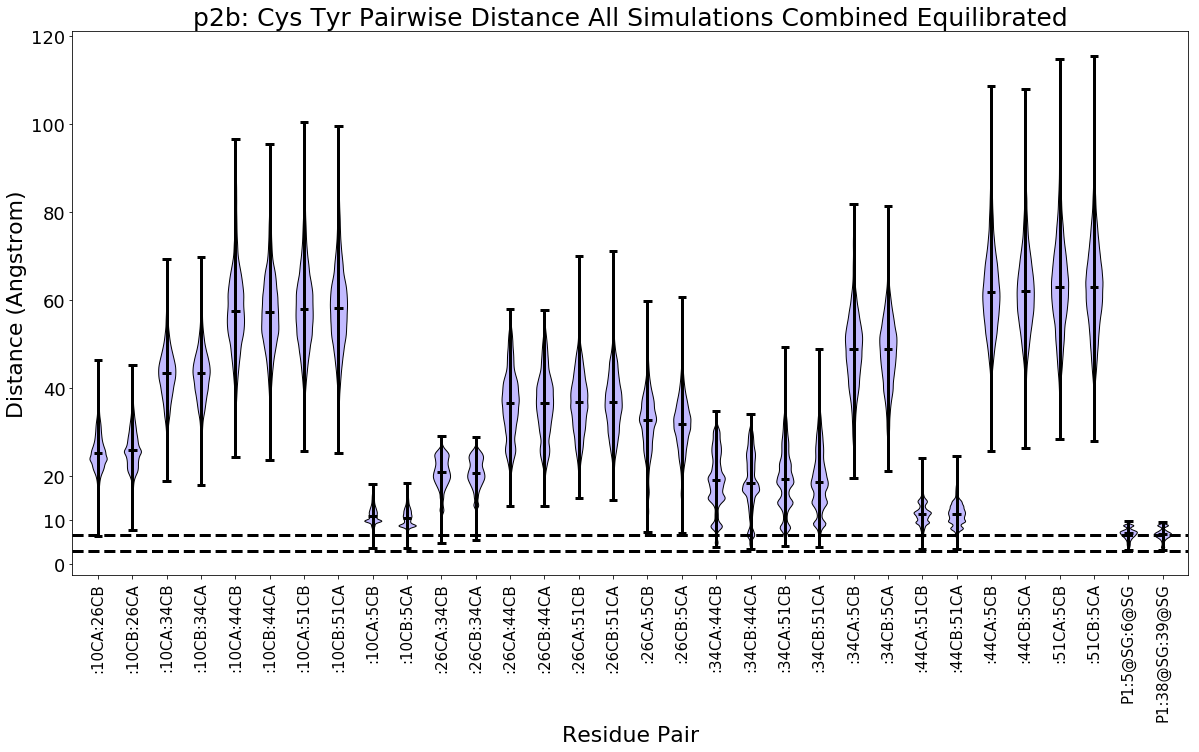

In [3]:
#disulfide bond check
#based on disulfide bond paper
def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels,fontsize=15,rotation=90)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Residue Pair', fontsize=22)
data = []
labels=[]
fig,ax = plt.subplots(figsize=(20, 10))
temp_p1=pd.read_csv("p1_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p1.sim.unique():
    temp_df = temp_p1[temp_p1.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p1 = blank_df.copy()
del temp_df
del blank_df
temp_p1=temp_p1[temp_p1.sim!=15]
temp_p1=temp_p1[temp_p1.sim!=13]
temp_p2b=pd.read_csv("p2b_cys_tyr_c_alpha_c_beta.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b.sim.unique():
    temp_df = temp_p2b[temp_p2b.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b = blank_df.copy()
del temp_df
del blank_df
temp_p2b=temp_p2b[temp_p2b.sim!=8]
temp_p2b=temp_p2b[temp_p2b.sim!=15]
for pair in temp_p2b.iloc[:,2:].columns:
    data.append(list(temp_p2b[pair].values))
    labels.append(str(pair))
data.append(list(temp_p1[':5:6'].values))
labels.append('P1:5@SG:6@SG')
data.append(list(temp_p1[':38:39'].values))
labels.append('P1:38@SG:39@SG')
ax.set_title('p2b: Cys Tyr Pairwise Distance All Simulations Combined Equilibrated',
             fontsize=25)
ax.set_ylabel('Distance (Angstrom)',fontsize=22)
#ax.set_ylim(11,37)
#ax.violinplot(data)
parts = ax.violinplot(
        data, showmeans=False, showmedians=True,
        showextrema=True)
for pc in parts['bodies']:
    pc.set_facecolor('#c2baff')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
parts['cmedians'].set_color('black')
parts['cbars'].set_color('black')
parts['cmins'].set_color('black')
parts['cmaxes'].set_color('black')
parts['cmedians'].set_linewidth(3)
parts['cbars'].set_linewidth(3)
parts['cmins'].set_linewidth(3)
parts['cmaxes'].set_linewidth(3)
set_axis_style(ax,labels)
plt.axhline(y=3,linewidth = 3, color='black',linestyle='dashed',label='10')
plt.axhline(y=6.5,linewidth = 3, color='black',linestyle='dashed',label='10')
#ax.annotate('10 Angstrom',xy=(2,10),fontsize=20)
#plt.xticks(np.arange(0,20,10)+)
extraticks=[10]
lim = ax.get_ylim()
ax.set_yticks(list(ax.get_yticks()) + extraticks)
ax.set_ylim(lim)
del temp_p2b
del temp_p1

In [8]:
#calpha_cbeta-calpha_cbeta distances are between 3 and 7.5 Angstrom, visually determined by PISCES histogram (Gao paper)
minimum_calpha_cbeta=3
maximum_calpha_cbeta=6.5
temp_p1=pd.read_csv("p1_cys_tyr_c_alpha_c_beta.csv")
blank_df = pd.DataFrame()
for sim in temp_p1.sim.unique():
    temp_df = temp_p1[temp_p1.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p1 = blank_df.copy()
del temp_df
del blank_df
temp_p1=temp_p1[temp_p1.sim!=15]
temp_p1=temp_p1[temp_p1.sim!=13]
temp_p2b=pd.read_csv("p2b_cys_tyr_c_alpha_c_beta.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b.sim.unique():
    temp_df = temp_p2b[temp_p2b.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b = blank_df.copy()
del temp_df
del blank_df
temp_p2b=temp_p2b[temp_p2b.sim!=8]
temp_p2b=temp_p2b[temp_p2b.sim!=15]
consecutive_pairs=[]
for i in range(2,len(temp_p1.columns)):
    first=int(temp_p1.columns[i].split('C')[0][1:len(temp_p1.columns[i].split('C')[0])])
    second=int(temp_p1.columns[i].split('C')[1][2:len(temp_p1.columns[i].split('C')[1])])
    if second-first==1:
        consecutive_pairs.append(temp_p1.columns[i])
    elif first-second==1:
        consecutive_pairs.append(temp_p1.columns[i])
close_pairs=[]
for i in range(2,len(temp_p2b.columns)):
    if temp_p2b[temp_p2b.columns[i]].values.min()<=maximum_calpha_cbeta and temp_p2b.columns[i] not in consecutive_pairs:
        close_pairs.append(temp_p2b.columns[i])
close_pairs_df=pd.DataFrame(data=close_pairs,columns=['pairs'])
close_pairs_df['number of simulations']=np.repeat(0,len(close_pairs_df))
frac_cut=0.20
close_pairs_df['simtime>'+str(frac_cut)]=np.repeat(0,len(close_pairs_df))
#count number of simulations in which close pairs get close and update close_pairs_df
sims=[]
for sim in temp_p2b.sim.unique():
    closepairs_bysim=[]
    closepairs_bysim=temp_p2b[close_pairs].columns[temp_p2b[temp_p2b.sim==sim][close_pairs].min()<=maximum_calpha_cbeta]
    simtime=len(temp_p2b[temp_p2b.sim==sim][close_pairs])
    pairs_time=temp_p2b[temp_p2b.sim==sim][close_pairs][temp_p2b[temp_p2b.sim==sim][close_pairs]<=maximum_calpha_cbeta]
    simtime_frac=(simtime-pairs_time.isna().sum())/simtime
    closepairs_bysimtime=temp_p2b[close_pairs].columns[simtime_frac>=frac_cut]
    if len(closepairs_bysim)!=0:
        close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysim),'number of simulations']=close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysim),'number of simulations']+1
        close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysimtime),'simtime>'+str(frac_cut)]=close_pairs_df.loc[close_pairs_df['pairs'].isin(closepairs_bysimtime),'simtime>'+str(frac_cut)]+1
del temp_p2b
del temp_p1
from tabulate import tabulate
print(tabulate(close_pairs_df, headers = 'keys', tablefmt = 'pretty'))

+----+------------+-----------------------+-------------+
|    |   pairs    | number of simulations | simtime>0.2 |
+----+------------+-----------------------+-------------+
| 0  | :10CA:26CB |           1           |      0      |
| 1  | :10CA:5CB  |           7           |      0      |
| 2  | :10CB:5CA  |           7           |      0      |
| 3  | :26CA:34CB |           1           |      0      |
| 4  | :26CB:34CA |           2           |      0      |
| 5  | :34CA:44CB |           3           |      1      |
| 6  | :34CB:44CA |           4           |      2      |
| 7  | :34CA:51CB |           4           |      0      |
| 8  | :34CB:51CA |           4           |      0      |
| 9  | :44CA:51CB |           8           |      1      |
| 10 | :44CB:51CA |           6           |      0      |
+----+------------+-----------------------+-------------+


In [5]:
%%time
#Calpha-calpha, calpha-cbeta, sulfur-sulfur - ALL TOGETHER in the same frame.(Jesse's suggestion)
#temp_p1_s is included because this is where consecutive cysteine sulfur information is derived
temp_p1_s=pd.read_csv("p1_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p1_s.sim.unique():
    temp_df = temp_p1_s[temp_p1_s.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p1_s = blank_df.copy()
del temp_df
del blank_df
temp_p1_s=temp_p1_s[temp_p1_s.sim!=15]
temp_p1_s=temp_p1_s[temp_p1_s.sim!=13]
temp_p2b_s=pd.read_csv("p2b_cys_tyr_dist.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b_s.sim.unique():
    temp_df = temp_p2b_s[temp_p2b_s.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b_s = blank_df.copy()
del temp_df
del blank_df
temp_p2b_s=temp_p2b_s[temp_p2b_s.sim!=14]
temp_p2b_s=temp_p2b_s[temp_p2b_s.sim!=13]
temp_p2b_calpha=pd.read_csv("p2b_cys_tyr_dist_C_alpha.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b_calpha.sim.unique():
    temp_df = temp_p2b_calpha[temp_p2b_calpha.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b_calpha = blank_df.copy()
del temp_df
del blank_df
temp_p2b_calpha=temp_p2b_calpha[temp_p2b_calpha.sim!=14]
temp_p2b_calpha=temp_p2b_calpha[temp_p2b_calpha.sim!=13]
temp_p2b_calpha_cbeta=pd.read_csv("p2b_cys_tyr_c_alpha_c_beta.csv")
blank_df = pd.DataFrame()
for sim in temp_p2b_calpha_cbeta.sim.unique():
    temp_df = temp_p2b_calpha_cbeta[temp_p2b_calpha_cbeta.sim==sim].iloc[-40000:,:]
    blank_df = blank_df.append(temp_df)
temp_p2b_calpha_cbeta = blank_df.copy()
del temp_df
del blank_df
temp_p2b_calpha_cbeta=temp_p2b_calpha_cbeta[temp_p2b_calpha_cbeta.sim!=14]
temp_p2b_calpha_cbeta=temp_p2b_calpha_cbeta[temp_p2b_calpha_cbeta.sim!=13]
#consecutive pair information only taken from p1. p2b or p2b do not have consecutive cysteines
consecutive_pairs_s=[]
for i in range(2,len(temp_p1_s.columns)):
    first=int(temp_p1_s.columns[i].split(':')[1])
    second=int(temp_p1_s.columns[i].split(':')[2])
    if second-first==1:
        consecutive_pairs_s.append(temp_p1_s.columns[i])
    elif first-second==1:
        consecutive_pairs_s.append(temp_p1_s.columns[i])
max_s=temp_p1_s[consecutive_pairs_s].values.max()
max_calpha=7.5
max_calpha_cbeta=6.5
common_close_pairs=[]
temp_p2b_combined=pd.concat([temp_p2b_s,temp_p2b_calpha,temp_p2b_calpha_cbeta],axis=1)
temp_p2b_combined=temp_p2b_combined[temp_p2b_combined.columns[temp_p2b_combined.columns!='frames']]
temp_p2b_combined=temp_p2b_combined[temp_p2b_combined.columns[temp_p2b_combined.columns!='sim']]
s_calpha_cbeta_index=[[i, element] for i,element in enumerate(temp_p2b_combined.columns)]
calpha_index=[]
calpha_cbeta_index=[]
for pair in s_calpha_cbeta_index:
    if '@CA' in pair[1]:
        calpha_index.append(pair[0])
        break
for pair in s_calpha_cbeta_index:
    if 'CB' in pair[1]:
        calpha_cbeta_index.append(pair[0])
        break
first_part=temp_p2b_combined.iloc[:,0:calpha_index[0]]<=max_s
second_part=temp_p2b_combined.iloc[:,calpha_index[0]:(calpha_cbeta_index[0])]<=max_calpha
third_part=temp_p2b_combined.iloc[:,calpha_cbeta_index[0]:]<=max_calpha_cbeta
temp_p2b_combined_bool = pd.concat([first_part,second_part,third_part],axis=1)
del first_part
del second_part
del third_part
temp_p2b_s_calpha_cbeta_conditionpairs=temp_p2b_combined[temp_p2b_combined_bool].dropna(axis=1,how='all')
s_calpha_cbeta_index=[[i, element] for i,element in enumerate(temp_p2b_s_calpha_cbeta_conditionpairs.columns)]
calpha_index=[]
calpha_cbeta_index=[]
for pair in s_calpha_cbeta_index:
    if '@CA' in pair[1]:
        calpha_index.append(pair[0])
        break
for pair in s_calpha_cbeta_index:
    if 'CB' in pair[1]:
        calpha_cbeta_index.append(pair[0])
        break
first_part=temp_p2b_combined[temp_p2b_combined_bool].dropna(axis=1,how='all').iloc[:,:calpha_index[0]]
second_part=temp_p2b_combined[temp_p2b_combined_bool].dropna(axis=1,how='all').iloc[:,calpha_index[0]:calpha_cbeta_index[0]]
third_part=temp_p2b_combined[temp_p2b_combined_bool].dropna(axis=1,how='all').iloc[:,calpha_cbeta_index[0]:]
nonconsecutive_residues_s=[]
nonconsecutive_residues_calpha=[]
nonconsecutive_residues_calpha_cbeta=[]
for i in range(0,len(first_part.columns)):
    first=int(first_part.columns[i].split(':')[1])
    second=int(first_part.columns[i].split(':')[2])
    if abs(second-first)!=1:
        nonconsecutive_residues_s.append([[first,second],first_part.columns[i]])
for i in range(0,len(second_part.columns)):
    first=int(second_part.columns[i].split('@CA')[0][1:len(second_part.columns[i].split('@CA')[0])])
    second=int(second_part.columns[i].split('@CA')[1][1:len(second_part.columns[i].split('@CA')[1])])
    if abs(first-second)!=1:
        nonconsecutive_residues_calpha.append([[first,second],second_part.columns[i]])
for i in range(0,len(third_part.columns)):
    first=int(third_part.columns[i].split('C')[0][1:len(third_part.columns[i].split('C')[0])])
    second=int(third_part.columns[i].split('C')[1][2:len(third_part.columns[i].split('C')[1])])
    if abs(second-first)!=1:
        nonconsecutive_residues_calpha_cbeta.append([[first,second],third_part.columns[i]])
residue_s_list=[residue_pair[0] for residue_pair in nonconsecutive_residues_s]
residue_calpha_list=[residue_pair[0] for residue_pair in nonconsecutive_residues_calpha]
residue_calpha_cbeta_list=[residue_pair[0] for residue_pair in nonconsecutive_residues_calpha_cbeta]
common_close_pairs=[]
#because i am expecting nonconsecutive_residues_calpha_cbeta to be biggest since it has Calpha-Cbeta and Cbeta-Calpha pairs
for pair in residue_calpha_cbeta_list:
    if pair in residue_s_list:
        if pair in residue_calpha_list:
            common_close_pairs.append(pair)
common_close_pairs_all=[]
for pair in nonconsecutive_residues_s:
    if pair[0] in common_close_pairs:
        common_close_pairs_all.append(pair[1])
for pair in nonconsecutive_residues_calpha:
    if pair[0] in common_close_pairs:
        common_close_pairs_all.append(pair[1])
for pair in nonconsecutive_residues_calpha_cbeta:
    if pair[0] in common_close_pairs:
        common_close_pairs_all.append(pair[1])
merged_s_calpha_cbeta = pd.concat([first_part,second_part,third_part],axis=1)
merged_s_calpha_cbeta_commonpairs=merged_s_calpha_cbeta[common_close_pairs_all]
merged_s_calpha_cbeta_commonpairs_commonframes_all=list()
merged_s_calpha_cbeta_commonpairs_commonframes_first=list()
merged_s_calpha_cbeta_commonpairs_commonframes_second=list()
merged_s_calpha_cbeta_commonpairs_commonframes_combined=list()
s_calpha_cbeta_index=[[i, element] for i,element in enumerate(merged_s_calpha_cbeta_commonpairs.columns)]
calpha_index=[]
calpha_cbeta_index=[]
for pair in s_calpha_cbeta_index:
    if '@CA' in pair[1]:
        calpha_index.append(pair[0])
        break
for pair in s_calpha_cbeta_index:
    if 'CB' in pair[1]:
        calpha_cbeta_index.append(pair[0])
        break
for i,j,k in zip(range(0,len(merged_s_calpha_cbeta_commonpairs.columns[0:calpha_index[0]])),
              range(calpha_index[0],calpha_index[0]+len(merged_s_calpha_cbeta_commonpairs.columns[calpha_index[0]:calpha_cbeta_index[0]])),
                range(calpha_cbeta_index[0],calpha_cbeta_index[0]+len(merged_s_calpha_cbeta_commonpairs.columns[calpha_cbeta_index[0]:len(merged_s_calpha_cbeta_commonpairs.columns)]))[1::2]):
    merged_s_calpha_cbeta_commonpairs_commonframes_all.append(merged_s_calpha_cbeta_commonpairs.dropna(axis=0,how='any',subset=merged_s_calpha_cbeta_commonpairs.columns[[i,j,k-1,k]])[merged_s_calpha_cbeta_commonpairs.columns[[i,j,k-1,k]]])
    merged_s_calpha_cbeta_commonpairs_commonframes_first.append(merged_s_calpha_cbeta_commonpairs.dropna(axis=0,how='any',subset=merged_s_calpha_cbeta_commonpairs.columns[[i,j,k-1]])[merged_s_calpha_cbeta_commonpairs.columns[[i,j,k-1]]])
    merged_s_calpha_cbeta_commonpairs_commonframes_second.append(merged_s_calpha_cbeta_commonpairs.dropna(axis=0,how='any',subset=merged_s_calpha_cbeta_commonpairs.columns[[i,j,k]])[merged_s_calpha_cbeta_commonpairs.columns[[i,j,k]]])
    merged_s_calpha_cbeta_commonpairs_commonframes_combined.append(merged_s_calpha_cbeta_commonpairs[merged_s_calpha_cbeta_commonpairs.columns[[i,j,k-1,k]]].loc[merged_s_calpha_cbeta_commonpairs.dropna(axis=0,how='any',subset=merged_s_calpha_cbeta_commonpairs.columns[[i,j,k]])[merged_s_calpha_cbeta_commonpairs.columns[[i,j,k]]].index.union(merged_s_calpha_cbeta_commonpairs.dropna(axis=0,how='any',subset=merged_s_calpha_cbeta_commonpairs.columns[[i,j,k-1,k]])[merged_s_calpha_cbeta_commonpairs.columns[[i,j,k-1,k]]].index.union(merged_s_calpha_cbeta_commonpairs.dropna(axis=0,how='any',subset=merged_s_calpha_cbeta_commonpairs.columns[[i,j,k-1]])[merged_s_calpha_cbeta_commonpairs.columns[[i,j,k-1]]].index))])
merged_s_calpha_cbeta_commonpairs_commonframes_combined_df=pd.DataFrame(columns=['residue_pair','total_number_of_frames','%frames'])
for index,dataframe in enumerate(merged_s_calpha_cbeta_commonpairs_commonframes_combined):
    merged_s_calpha_cbeta_commonpairs_commonframes_combined_df.loc[index,:]=[dataframe.columns[0],len(dataframe),format(100*(len(dataframe)/len(merged_s_calpha_cbeta_commonpairs)),'2.2f')]
from tabulate import tabulate
print(tabulate(merged_s_calpha_cbeta_commonpairs_commonframes_combined_df, headers = 'keys', tablefmt = 'pretty'))

+---+--------------+------------------------+---------+
|   | residue_pair | total_number_of_frames | %frames |
+---+--------------+------------------------+---------+
| 0 |    :10:5     |         44123          |  8.49   |
| 1 |    :26:34    |           58           |  0.01   |
| 2 |    :34:44    |         22837          |  4.39   |
| 3 |    :34:51    |          4608          |  0.89   |
| 4 |    :44:51    |         10686          |  2.05   |
+---+--------------+------------------------+---------+
CPU times: user 35.8 s, sys: 4.31 s, total: 40.1 s
Wall time: 40.5 s
